In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl 
from rasterio import features
from affine import Affine
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas
import seaborn as sns
import scipy


def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

def calc_change(da1, da2, N, var):
    
    days1 = len(da1.attrs["daily_time"]) 
    days2 = len(da2.attrs["daily_time"])     
    
    change = ((da2[var].sum("year_month",skipna=False) / days2) - (da1[var].sum("year_month",skipna=False) / days1))
    
    combined = xr.concat([da1[var],da2[var]],dim="year_month").persist()

    resampled = []
    for n in np.arange(N):

        random_samp1 = combined.isel(year_month=np.random.randint(0,da1.year_month.shape[0],da1.year_month.shape[0]))
        random_samp2 = combined.isel(year_month=np.random.randint(0,da2.year_month.shape[0],da2.year_month.shape[0]))
        resampled.append(((random_samp2.sum("year_month",skipna=False) / days2) - (random_samp1.sum("year_month",skipna=False) / days1)))

    resampled = xr.concat(resampled,dim="resamples")
    q2p5 = resampled.quantile(0.025,"resamples",skipna=True)
    q97p5 = resampled.quantile(0.975,"resamples",skipna=False)   
    
    lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/static/lnd_mask-BARPA-EASTAUS_12km.nc").\
        rename({"latitude":"lat","longitude":"lon"}).interp_like(resampled,method="nearest")
    
    return change, xr.where(lsm.lnd_mask==1,q2p5,np.nan), xr.where(lsm.lnd_mask==1,q97p5,np.nan)

def calc_change_conditional(da1, da2, da1_cond, da2_cond, N, var, var_cond):
    
    days1 = len(da1.attrs["daily_time"]) 
    days2 = len(da2.attrs["daily_time"])     
    
    change = ((da2[var].sum("year_month",skipna=False) / days2) / (da2_cond[var_cond].sum("year_month",skipna=False) / days2)) \
                - ((da1[var].sum("year_month",skipna=False) / days1) / (da1_cond[var_cond].sum("year_month",skipna=False) / days1))
    
    combined = xr.concat([da1[var],da2[var]],dim="year_month").persist()
    combined_cond = xr.concat([da1_cond[var_cond],da2_cond[var_cond]],dim="year_month").persist()    

    resampled = []
    for n in np.arange(N):

        randint1 = np.random.randint(0,da1.year_month.shape[0],da1.year_month.shape[0])
        randint2 = np.random.randint(0,da2.year_month.shape[0],da2.year_month.shape[0])
        
        random_samp1 = combined.isel(year_month=randint1)
        random_samp2 = combined.isel(year_month=randint2)
        
        random_samp_cond1 = combined_cond.isel(year_month=randint1)
        random_samp_cond2 = combined_cond.isel(year_month=randint2)        
        
        resampled.append(
            ((random_samp2.sum("year_month",skipna=False) / days2) / (random_samp_cond2.sum("year_month",skipna=False) / days2)) -\
             ((random_samp1.sum("year_month",skipna=False) / days1) / (random_samp_cond1.sum("year_month",skipna=False) / days1)))

    resampled = xr.concat(resampled,dim="resamples")
    q2p5 = resampled.quantile(0.025,"resamples",skipna=True)
    q97p5 = resampled.quantile(0.975,"resamples",skipna=False)   
    
    lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/static/lnd_mask-BARPA-EASTAUS_12km.nc").\
        rename({"latitude":"lat","longitude":"lon"}).interp_like(resampled,method="nearest")
    
    
    return change, xr.where(lsm.lnd_mask==1,q2p5,np.nan), xr.where(lsm.lnd_mask==1,q97p5,np.nan)

def resample_mean(da, N=1000, norm=False, norm_da=None):
    
    da = da.coarsen({"year_month":3}).sum().sum(("lat","lon"))
    if norm:
        da = da / norm_da.coarsen({"year_month":3}).sum().sum(("lat","lon"))
    resampled = []
    for n in np.arange(N):
        randint = np.random.randint(0,da.year_month.shape[0],da.year_month.shape[0])
        random_samp = da.isel(year_month=randint)
        resampled.append(np.mean(random_samp.values))
    
    return np.percentile(resampled, [2.5,97.5])

def resample_mean_prob(da, days, lsm_count, N=1000, cond=False, cond_da=None):
    
    da = da.coarsen({"year_month":3}).sum().sum(("lat","lon"))
    if cond:
        cond_da = cond_da.coarsen({"year_month":3}).sum().sum(("lat","lon"))
    resampled = []
    for n in np.arange(N):
        randint = np.random.randint(0,da.year_month.shape[0],da.year_month.shape[0])
        random_samp = da.isel(year_month=randint)
        p1 = (np.sum(random_samp.values)) / (lsm_count * days)
        if cond:
            random_samp_cond = cond_da.isel(year_month=randint)
            p2 = (np.sum(random_samp_cond.values)) / (lsm_count * days)
            resampled.append(p1/p2)
        else:
            resampled.append(p1)
    
    return np.percentile(resampled, [2.5,97.5])

def calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster, nrm=0):

    if nrm >= 1:
        scws_hist = scws_hist.where(scws_hist.nrm==nrm, np.nan)
        scws_rcp = scws_rcp.where(scws_hist.nrm==nrm, np.nan)
        bdsd_hist = bdsd_hist.where(scws_hist.nrm==nrm, np.nan)
        bdsd_rcp = bdsd_rcp.where(scws_hist.nrm==nrm, np.nan)    
    
    if cluster=="all":
        
        scws_hist_ts = scws_hist.all_events.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        scws_rcp_ts = scws_rcp.all_events.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        scws_hist_base = np.mean(scws_hist_ts)

        bdsd_hist_ts = bdsd_hist.clusterall_bdsd.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        bdsd_rcp_ts = bdsd_rcp.clusterall_bdsd.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        bdsd_hist_base = np.mean(bdsd_hist_ts)
        
    elif cluster=="0":
        
        scws_hist_ts = scws_hist.cluster0_events.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        scws_rcp_ts = scws_rcp.cluster0_events.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        scws_hist_base = np.mean(scws_hist_ts)

        bdsd_hist_ts = bdsd_hist.cluster0_bdsd.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        bdsd_rcp_ts = bdsd_rcp.cluster0_bdsd.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        bdsd_hist_base = np.mean(bdsd_hist_ts)

        cluster_hist_ts = bdsd_hist.cluster0.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        cluster_rcp_ts = bdsd_rcp.cluster0.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        cluster_hist_base = np.mean(cluster_hist_ts)
        
    elif cluster=="1":
        
        scws_hist_ts = scws_hist.cluster1_events.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        scws_rcp_ts = scws_rcp.cluster1_events.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        scws_hist_base = np.mean(scws_hist_ts)

        bdsd_hist_ts = bdsd_hist.cluster1_bdsd.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        bdsd_rcp_ts = bdsd_rcp.cluster1_bdsd.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        bdsd_hist_base = np.mean(bdsd_hist_ts)

        cluster_hist_ts = bdsd_hist.cluster1.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        cluster_rcp_ts = bdsd_rcp.cluster1.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        cluster_hist_base = np.mean(cluster_hist_ts)
        
    elif cluster=="2":
        
        scws_hist_ts = scws_hist.cluster2_events.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        scws_rcp_ts = scws_rcp.cluster2_events.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        scws_hist_base = np.mean(scws_hist_ts)

        bdsd_hist_ts = bdsd_hist.cluster2_bdsd.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        bdsd_rcp_ts = bdsd_rcp.cluster2_bdsd.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        bdsd_hist_base = np.mean(bdsd_hist_ts)

        cluster_hist_ts = bdsd_hist.cluster2.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        cluster_rcp_ts = bdsd_rcp.cluster2.coarsen({"year_month":3}).sum().sum(("lat","lon")).values
        cluster_hist_base = np.mean(cluster_hist_ts)  
        
    if cluster == "all":
        return scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base
    else:
        return scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base, cluster_hist_ts, cluster_rcp_ts, cluster_hist_base


In [2]:
lat_slice = slice(-44,-29.5)
lon_slice = slice(136,154)
rolling = 0

#Load output from spatial_barpa_analysis_prep.py
scws_hist = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpac_scws_hist_monthly.nc").sel(lat=lat_slice,lon=lon_slice)
scws_rcp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpac_scws_rcp_monthly.nc").sel(lat=lat_slice,lon=lon_slice)

max_hist = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpac_max_hist_monthly.nc").sel(lat=lat_slice,lon=lon_slice)
max_rcp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpac_max_rcp_monthly.nc").sel(lat=lat_slice,lon=lon_slice)

bdsd_hist = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpar_hist_monthly.nc").sel(lat=lat_slice,lon=lon_slice)
bdsd_rcp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpar_rcp_monthly.nc").sel(lat=lat_slice,lon=lon_slice)

scw_bdsd_hist = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpac_scws_bdsd_hist_monthly.nc").sel(lat=lat_slice,lon=lon_slice)
scw_bdsd_rcp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpac_scws_bdsd_rcp_monthly.nc").sel(lat=lat_slice,lon=lon_slice)

#Mask data over the ocean from BARPA-R
lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/static/lnd_mask-BARPA-EASTAUS_12km.nc").\
    rename({"latitude":"lat","longitude":"lon"}).interp_like(bdsd_hist,method="nearest")
bdsd_hist = xr.where(lsm.lnd_mask==1,bdsd_hist,np.nan,keep_attrs=True)
bdsd_rcp = xr.where(lsm.lnd_mask==1,bdsd_rcp,np.nan,keep_attrs=True)

#Option to do a rolling spatial mean
if rolling > 0:
    scws_hist = scws_hist.rolling(lat=rolling, lon=rolling, min_periods=1).mean()
    scws_rcp = scws_rcp.rolling(lat=rolling, lon=rolling, min_periods=1).mean()    
    
    scw_bdsd_hist = scw_bdsd_hist.rolling(lat=rolling, lon=rolling, min_periods=1).mean()
    scw_bdsd_rcp = scw_bdsd_rcp.rolling(lat=rolling, lon=rolling, min_periods=1).mean()    
    
#Add NRM mask to the historical simulated SCW dataset
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
f = geopandas.read_file("/home/548/ab4502/working/NRM_super_clusters/NRM_super_clusters.shp")
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
scws_hist["nrm"] = rasterize(shapes, {"lon":scws_hist.lon,"lat":scws_hist.lat})
scws_hist["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":scws_hist.lon,"lat":scws_hist.lat})

/jobfs/105905596.gadi-pbs/ipykernel_2751541/1321275678.py:33: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


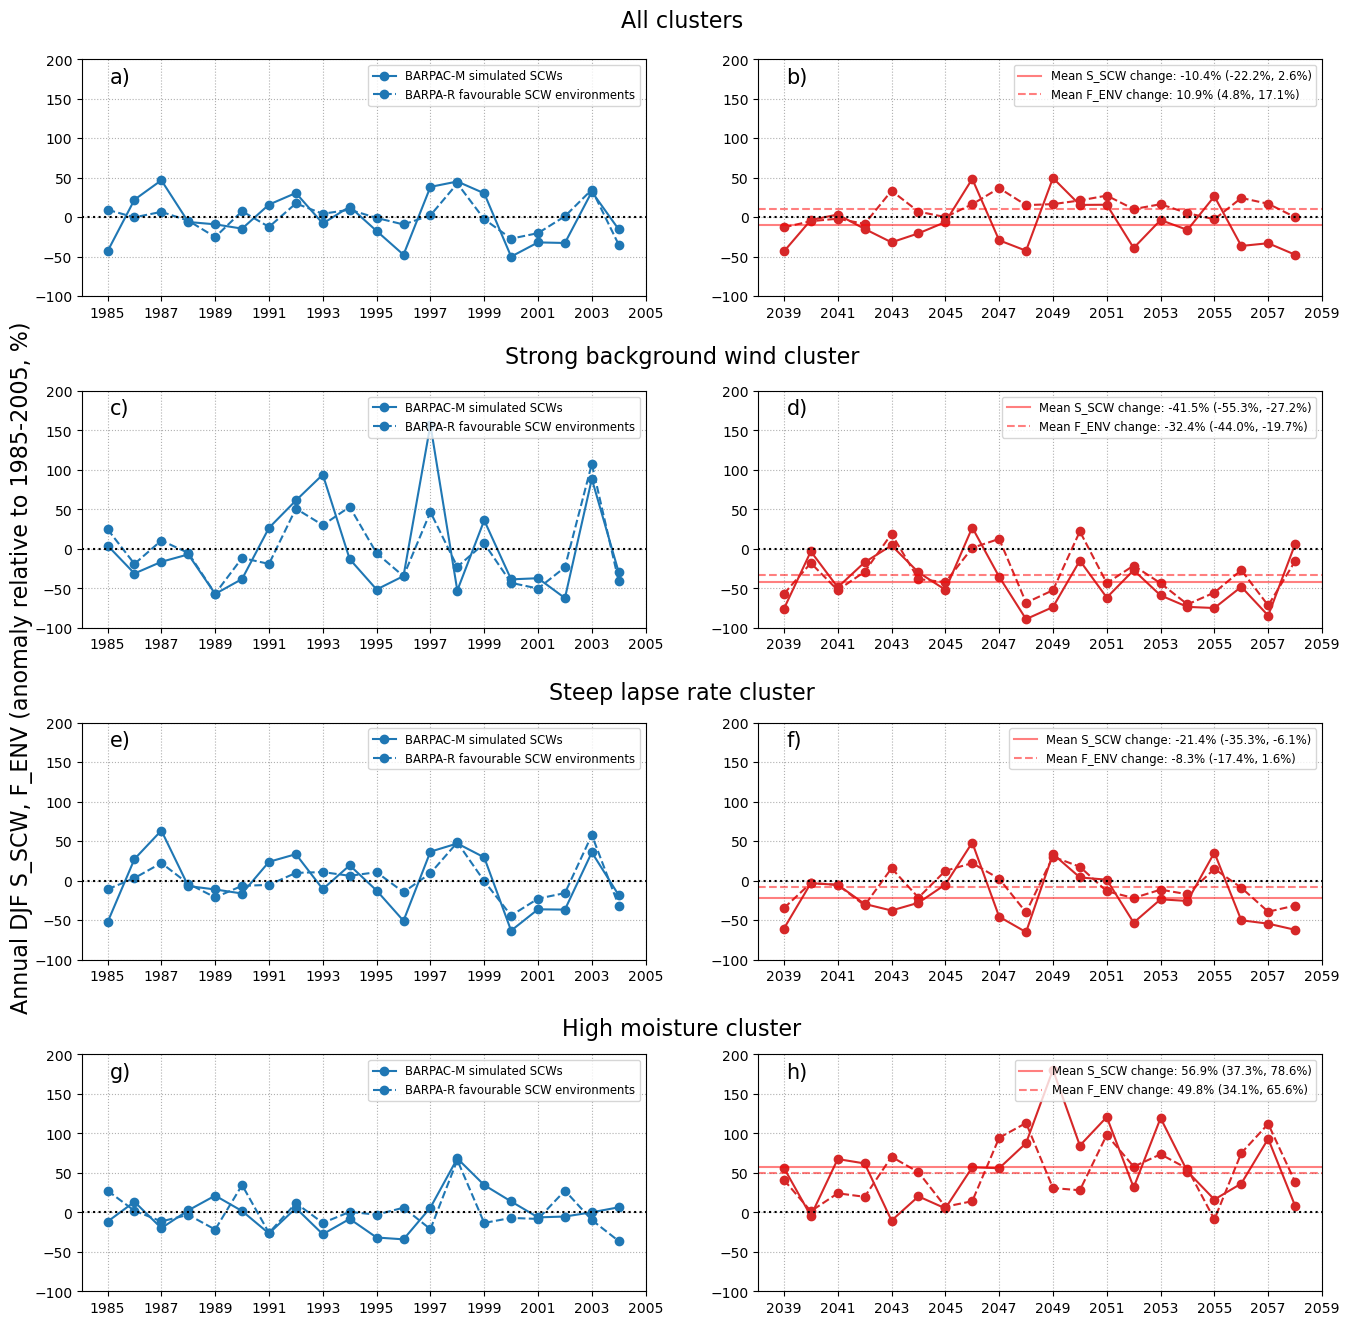

In [3]:
#Look at time series of annual, domain-wide occurrences of favourable environments (F_ENV) and simulated SCWs (S_SCWs).
#Do this for each cluster, and look at correlations between S_SCW and F_ENV.

def plot_ts(cluster, row, col, p1, p2, cluster_label, letters):   
        
    np.random.seed(0)    
        
    if cluster=="all":
        scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base = \
                    calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster)        
    else:
        scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base, cluster_hist_ts, cluster_rcp_ts, cluster_hist_base = \
                    calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster)
        
    if cluster=="all":
        scw_var="all_events"
        bdsd_var="clusterall_bdsd"
    elif cluster=="0":
        scw_var="cluster0_events"
        bdsd_var="cluster0_bdsd"
        cluster_var="cluster0"        
    elif cluster=="1":
        scw_var="cluster1_events"
        bdsd_var="cluster1_bdsd"      
        cluster_var="cluster1"                
    elif cluster=="2":
        scw_var="cluster2_events"  
        bdsd_var="cluster2_bdsd"      
        cluster_var="cluster2"                
        
    bounds = [str(x)+"%" for x in ((resample_mean(scws_rcp[scw_var]) - scws_hist_base) / scws_hist_base * 100).round(1)]
    scw_label = "Mean S_SCW change: {a}% ({b}, {c})".format(a=np.mean((scws_rcp_ts - scws_hist_base) / scws_hist_base * 100).round(1), b=bounds[0], c=bounds[1])
    
    bounds = [str(x)+"%" for x in ((resample_mean(bdsd_rcp[bdsd_var]) - bdsd_hist_base) / bdsd_hist_base * 100).round(1)]
    bdsd_label = "Mean F_ENV change: {a}% ({b}, {c})".format(a=np.mean((bdsd_rcp_ts - bdsd_hist_base) / bdsd_hist_base * 100).round(1), b=bounds[0], c=bounds[1])
        
    plt.subplot(row,col,p1)
    plt.plot((scws_hist_ts - scws_hist_base) / scws_hist_base * 100, marker="o", color="tab:blue",ls="-",label="BARPAC-M simulated SCWs")
    plt.plot((bdsd_hist_ts - bdsd_hist_base) / bdsd_hist_base * 100, marker="o", color="tab:blue",ls="--",label="BARPA-R favourable SCW environments")
    # if cluster != "all":
    #     plt.plot((cluster_hist_ts - cluster_hist_base) / cluster_hist_base * 100, marker="o", color="k",ls="--",label="BARPA-R "+cluster_label+" cluster")    
    plt.gca().grid(ls=":")
    plt.ylim([-100,200])
    plt.legend(fontsize="small",loc=1)
    plt.gca().axhline(color="k",ls=":") 
    plt.xticks(np.arange(0,21,2),np.arange(1985,2006,2))
    plt.text(0.05,0.9,letters[0]+")",transform=plt.gca().transAxes,size=15)    

    plt.subplot(row,col,p2)
    plt.plot((scws_rcp_ts - scws_hist_base) / scws_hist_base * 100, marker="o", color="tab:red", ls="-")
    plt.plot((bdsd_rcp_ts - bdsd_hist_base) / bdsd_hist_base * 100, marker="o", color="tab:red", ls="--")
    # if cluster != "all":
    #     plt.plot((cluster_rcp_ts - cluster_hist_base) / cluster_hist_base * 100, marker="o", color="k", ls="--")    
    plt.gca().grid(ls=":")
    plt.gca().axhline(np.mean((scws_rcp_ts - scws_hist_base) / scws_hist_base * 100),color="r", ls="-", label=scw_label, alpha=0.5)
    plt.gca().axhline(np.mean((bdsd_rcp_ts - bdsd_hist_base) / bdsd_hist_base * 100),color="r", ls="--", label=bdsd_label, alpha=0.5)
    # if cluster != "all":
    #     bounds = [str(x)+"%" for x in ((resample_mean(bdsd_rcp[cluster_var]) - cluster_hist_base) / cluster_hist_base * 100).round(1)]
    #     cluster_label = "Cluster change: {a}% ({b}, {c})".format(a=np.mean((cluster_rcp_ts - cluster_hist_base) / cluster_hist_base * 100).round(1), b=bounds[0], c=bounds[1])        
    #     plt.gca().axhline(np.mean((cluster_rcp_ts - cluster_hist_base) / cluster_hist_base * 100),color="k", ls="--", alpha=0.5,label=cluster_label)
    plt.ylim([-100,200])
    plt.gca().axhline(color="k",ls=":")  
    plt.xticks(np.arange(0,21,2),np.arange(2039,2060,2))    
    plt.legend(fontsize="small",loc=1)
    plt.text(0.05,0.9,letters[1]+")",transform=plt.gca().transAxes,size=15)    

    corr_hist = np.corrcoef((scws_hist_ts - scws_hist_base) / scws_hist_base, (bdsd_hist_ts - bdsd_hist_base) / bdsd_hist_base)[0,1]
    corr_rcp = np.corrcoef((scws_rcp_ts - scws_hist_base) / scws_hist_base, (bdsd_rcp_ts - bdsd_hist_base) / bdsd_hist_base)[0,1]
    
    return corr_hist, corr_rcp
    
plt.figure(figsize=[16,16])

corr_hist, corr_rcp = plot_ts("all", 4, 2, 1, 2, "",["a","b"])
corr_hist0, corr_rcp0 = plot_ts("0", 4, 2, 3, 4, "Strong background wind",["c","d"])
corr_hist1, corr_rcp1 = plot_ts("1", 4, 2, 5, 6, "Steep lapse rate",["e","f"])
corr_hist2, corr_rcp2 = plot_ts("2", 4, 2, 7, 8, "High moisture",["g","h"])

plt.subplots_adjust(hspace=0.4)

plt.gcf().text(0.08,0.5,"Annual DJF S_SCW, F_ENV (anomaly relative to 1985-2005, %)",rotation=90,va="center",size=16) 
plt.gcf().text(0.5,0.9,"All clusters",ha="center",size=16) 
plt.gcf().text(0.5,0.69,"Strong background wind cluster",ha="center",size=16) 
plt.gcf().text(0.5,0.48,"Steep lapse rate cluster",ha="center",size=16) 
plt.gcf().text(0.5,0.27,"High moisture cluster",ha="center",size=16) 

plt.savefig("/g/data/eg3/ab4502/figs/barpa/future_changes_barpacm.jpeg",dpi=400,bbox_inches="tight")

In [4]:
#Correlation between annual number of S_SCWs and F_ENVs

df = pd.DataFrame({"Historical":[x.round(3) for x in [corr_hist,corr_hist0,corr_hist1,corr_hist2]],
             "Future":[x.round(3) for x in [corr_rcp,corr_rcp0,corr_rcp1,corr_rcp2]]},
             index=["All events","Strong background wind events","Steep lapse rate events","High moisture events"])
print(df)
df.to_csv("/g/data/eg3/ab4502/figs/barpa/fenv_sscw_corr_table.csv")

                               Historical  Future
All events                          0.565   0.042
Strong background wind events       0.737   0.829
Steep lapse rate events             0.750   0.787
High moisture events                0.367   0.338


In [5]:
#Correlation for annual and monthly anomalies

def annual_corr(da1,da2,N=1000,return_ts=False):
    
    da1_ts = da1.coarsen({"year_month":3}).sum().mean((("lat","lon"))).values
    da2_ts = da2.coarsen({"year_month":3}).sum().mean((("lat","lon"))).values
    da1_ts = da1_ts - np.mean(da1_ts)
    da2_ts = da2_ts - np.mean(da2_ts)

    corr =  np.corrcoef(da1_ts, da2_ts)[1,0].round(3)
    corr_resample = []
    for n in np.arange(0,N):
        ind = np.random.randint(0,len(da1_ts),len(da1_ts))
        corr_resample.append(np.corrcoef(da1_ts[ind], da2_ts[ind])[1,0])
        
    if return_ts:
        return da1_ts, da2_ts, np.polyfit(da1_ts, da2_ts, 1)[0], corr
    else:
        return str(corr) + " (" + str(np.percentile(corr_resample,2.5).round(3)) + ", " + str(np.percentile(corr_resample,97.5).round(3))+")"

def monthly_corr(da1,da2,N=1000,return_ts=False):
    
    da1_ts_all = []
    da2_ts_all = []
    for m in [12,1,2]:
        month_ind = np.array([int(x[4:]) for x in da1.year_month.values]) == m
        da1_ts = da1.sel(year_month=month_ind).mean((("lat","lon"))).values
        da1_ts_all = np.concatenate([da1_ts_all,da1_ts - np.mean(da1_ts)])

        month_ind = np.array([int(x[4:]) for x in da2.year_month.values]) == m
        da2_ts = da2.sel(year_month=month_ind).mean((("lat","lon"))).values
        da2_ts_all = np.concatenate([da2_ts_all,da2_ts - np.mean(da2_ts)])

        
    corr =  np.corrcoef(da1_ts, da2_ts)[1,0].round(3)
    corr_resample = []
    for n in np.arange(0,N):
        ind = np.random.randint(0,len(da1_ts),len(da1_ts))
        corr_resample.append(np.corrcoef(da1_ts[ind], da2_ts[ind])[1,0])        
        
    if return_ts:
        return da1_ts_all, da2_ts_all, np.polyfit(da1_ts, da2_ts, 1)[0], corr
    else:
        return str(corr) + " (" + str(np.percentile(corr_resample,2.5).round(3)) + ", " + str(np.percentile(corr_resample,97.5).round(3))+")"

    
hist = []
rcp = []

hist.append(annual_corr(scws_hist.all_events, bdsd_hist.clusterall_bdsd))
rcp.append(annual_corr(scws_rcp.all_events, bdsd_rcp.clusterall_bdsd))

hist.append(monthly_corr(scws_hist.all_events, bdsd_hist.clusterall_bdsd))
rcp.append(monthly_corr(scws_rcp.all_events, bdsd_rcp.clusterall_bdsd))

df=pd.DataFrame({"Historical":hist, "Mid-century":rcp},index=["Annual anomalies","Monthly anomalies"])
df.to_csv("/g/data/eg3/ab4502/figs/barpa/fenv_sscw_corr_table2.csv")

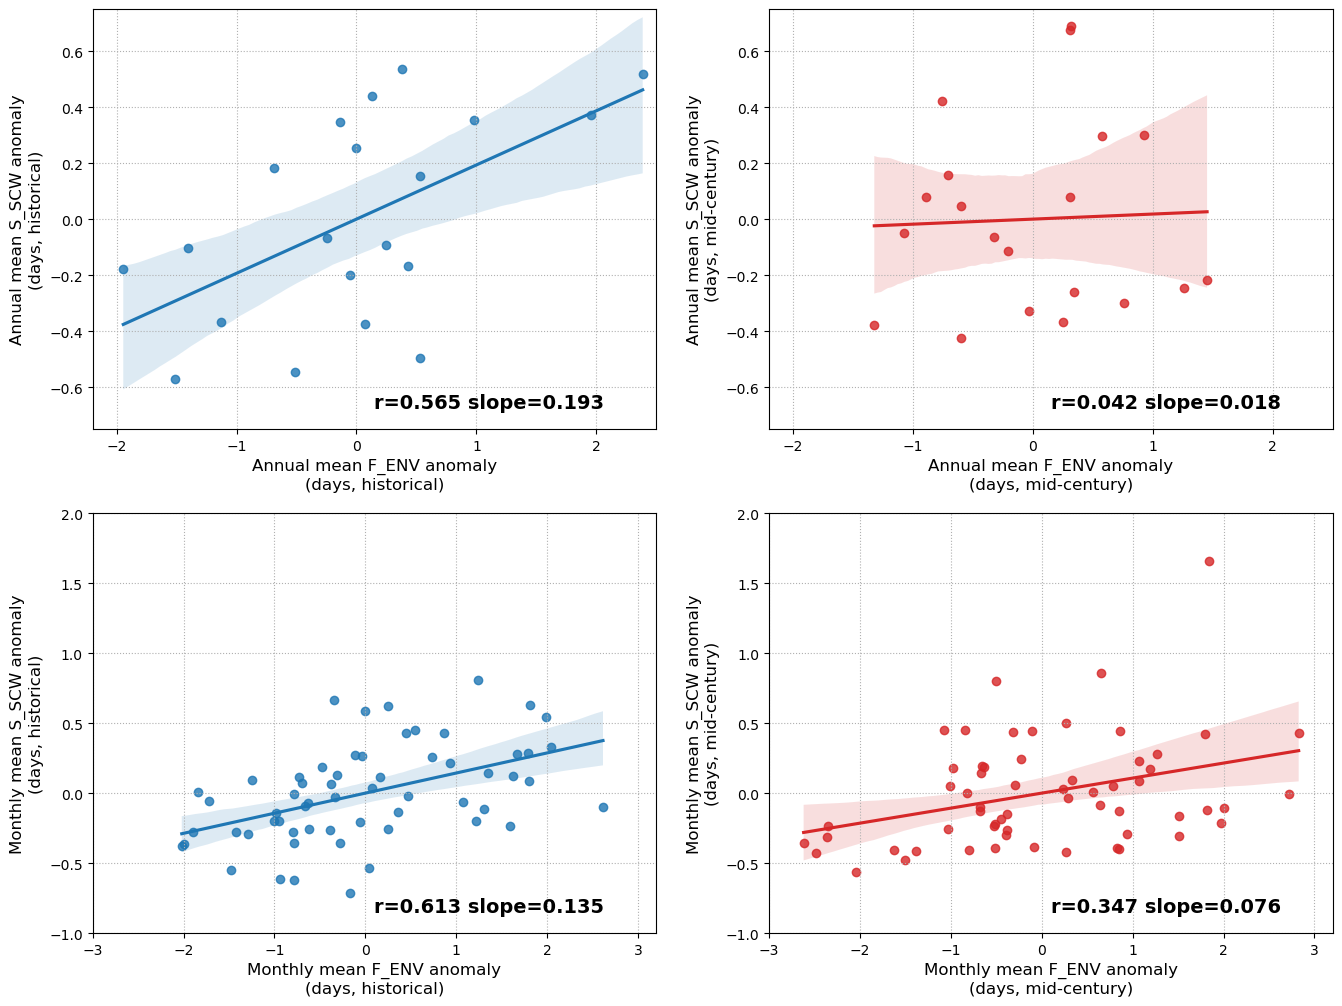

In [6]:
plt.figure(figsize=[16,12])

plt.subplot(2,2,1)
x,y,slope,corr=annual_corr(bdsd_hist.clusterall_bdsd, scws_hist.all_events, return_ts=True)
sns.regplot(x=x,y=y,color="tab:blue")
plt.xlim([-2.2,2.5])
plt.ylim([-.75,.75])
plt.gca().grid(ls=":")
plt.text(0.5,0.05,"r="+str(corr.round(3))+" slope="+str(slope.round(3)),transform=plt.gca().transAxes,fontdict={"fontweight":"bold"},size=14)
plt.xlabel("Annual mean F_ENV anomaly\n(days, historical)",size=12)
plt.ylabel("Annual mean S_SCW anomaly\n(days, historical)",size=12)

plt.subplot(2,2,2)
x,y,slope,corr=annual_corr(bdsd_rcp.clusterall_bdsd, scws_rcp.all_events, return_ts=True)
sns.regplot(x=x,y=y,color="tab:red")
plt.text(0.5,0.05,"r="+str(corr.round(3))+" slope="+str(slope.round(3)),transform=plt.gca().transAxes,fontdict={"fontweight":"bold"},size=14)
plt.xlim([-2.2,2.5])
plt.ylim([-.75,.75])
plt.gca().grid(ls=":")
plt.xlabel("Annual mean F_ENV anomaly\n(days, mid-century)",size=12)
plt.ylabel("Annual mean S_SCW anomaly\n(days, mid-century)",size=12)

plt.subplot(2,2,3)
x,y,slope,corr=monthly_corr(bdsd_hist.clusterall_bdsd, scws_hist.all_events, return_ts=True)
sns.regplot(x=x,y=y,color="tab:blue")
plt.text(0.5,0.05,"r="+str(corr.round(3))+" slope="+str(slope.round(3)),transform=plt.gca().transAxes,fontdict={"fontweight":"bold"},size=14)
plt.ylim([-1,2])
plt.xlim([-3,3.2])
plt.gca().grid(ls=":")
plt.xlabel("Monthly mean F_ENV anomaly\n(days, historical)",size=12)
plt.ylabel("Monthly mean S_SCW anomaly\n(days, historical)",size=12)

plt.subplot(2,2,4)
x,y,slope,corr=monthly_corr(bdsd_rcp.clusterall_bdsd, scws_rcp.all_events, return_ts=True)
sns.regplot(x=x,y=y,color="tab:red")
plt.text(0.5,0.05,"r="+str(corr.round(3))+" slope="+str(slope.round(3)),transform=plt.gca().transAxes,fontdict={"fontweight":"bold"},size=14)
plt.ylim([-1,2])
plt.xlim([-3,3.2])
plt.gca().grid(ls=":")
plt.xlabel("Monthly mean F_ENV anomaly\n(days, mid-century)",size=12)
plt.ylabel("Monthly mean S_SCW anomaly\n(days, mid-century)",size=12)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/future_changes_barpacm_corr.jpeg",dpi=400,bbox_inches="tight")

                               Historical (S_SCW)  Future (S_SCW)  \
Strong background wind events               0.461           0.080   
Steep lapse rate events                     0.993           0.976   
High moisture events                        0.385           0.422   

                               Historical (F_ENV)  Future (F_ENV)  
Strong background wind events               0.674           0.442  
Steep lapse rate events                     0.893           0.312  
High moisture events                        0.640           0.643  


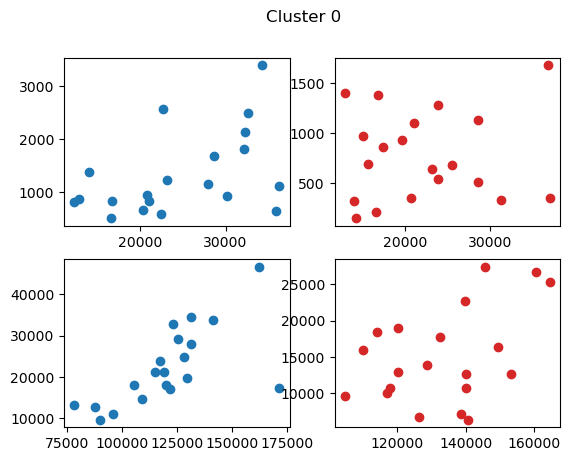

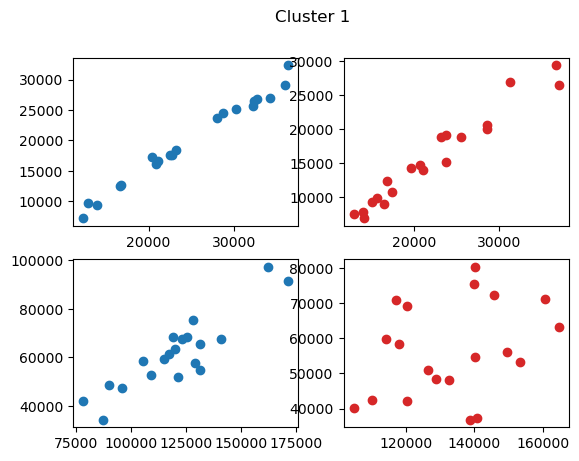

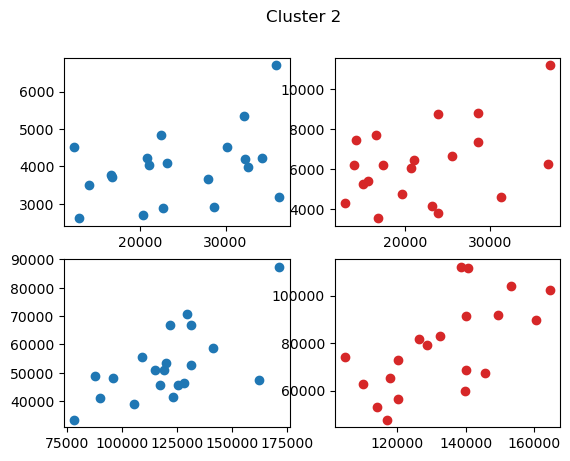

In [7]:
#Check correlations between each cluster and the overall number of events
scws_hist_ts_all, scws_rcp_ts_all, scws_hist_base_all, bdsd_hist_ts_all, bdsd_rcp_ts_all, bdsd_hist_base_all = \
            calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, "all")        

corr_bdsd_hist = []
corr_bdsd_rcp = []
corr_scw_hist = []
corr_scw_rcp = []

visualise = True
for cluster in ["0","1","2"]:
        scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base, cluster_hist_ts, cluster_rcp_ts, cluster_hist_base = \
                    calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster)

        corr_scw_hist.append(np.corrcoef((scws_hist_ts - scws_hist_base) / scws_hist_base, (scws_hist_ts_all - scws_hist_base_all) / scws_hist_base_all)[0,1].round(3))

        corr_scw_rcp.append(np.corrcoef((scws_rcp_ts - scws_hist_base) / scws_hist_base, (scws_rcp_ts_all - scws_hist_base_all) / scws_hist_base_all)[0,1].round(3))

        corr_bdsd_hist.append(np.corrcoef((bdsd_hist_ts - bdsd_hist_base) / bdsd_hist_base, (bdsd_hist_ts_all - bdsd_hist_base_all) / bdsd_hist_base_all)[0,1].round(3))

        corr_bdsd_rcp.append(np.corrcoef((bdsd_rcp_ts - bdsd_hist_base) / bdsd_hist_base, (bdsd_rcp_ts_all - bdsd_hist_base_all) / bdsd_hist_base_all)[0,1].round(3))
        
        if visualise:
            plt.figure()
            plt.subplot(2,2,1)
            plt.scatter(scws_hist_ts_all,scws_hist_ts)
            plt.subplot(2,2,2)
            plt.scatter(scws_rcp_ts_all,scws_rcp_ts,color="tab:red")
            plt.subplot(2,2,3)
            plt.scatter(bdsd_hist_ts_all,bdsd_hist_ts)
            plt.subplot(2,2,4)
            plt.scatter(bdsd_rcp_ts_all,bdsd_rcp_ts,color="tab:red")   
            plt.suptitle("Cluster "+cluster)
        
df=pd.DataFrame({"Historical (S_SCW)":corr_scw_hist,
              "Future (S_SCW)":corr_scw_rcp,
              "Historical (F_ENV)":corr_bdsd_hist,
              "Future (F_ENV)":corr_bdsd_rcp},
             index=["Strong background wind events","Steep lapse rate events","High moisture events"])        
print(df)
df.to_csv("/g/data/eg3/ab4502/figs/barpa/cluster_corr_table.csv")

In [8]:
#Print probabilities into a table

p_bdsd_hist = []
p_bdsd_rcp = []
p_scw_hist = []
p_scw_rcp = []

lsm_count = lsm.lnd_mask.values.sum()
days_hist = len(scws_hist.attrs["daily_time"])
days_rcp = len(scws_rcp.attrs["daily_time"])

for cluster in ["all","0","1","2"]:
    
        try:
            scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base, cluster_hist_ts, cluster_rcp_ts, cluster_hist_base = \
                        calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster)
        except:
            scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base = \
                        calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster)            

        p_scw_hist.append((np.sum(scws_hist_ts) / (lsm_count * days_hist)).round(4))

        p_scw_rcp.append((np.sum(scws_rcp_ts) / (lsm_count * days_rcp)).round(4))

        p_bdsd_hist.append((np.sum(bdsd_hist_ts) / (lsm_count * days_hist)).round(4))

        p_bdsd_rcp.append((np.sum(bdsd_rcp_ts) / (lsm_count * days_rcp)).round(4))
        
df=pd.DataFrame({"Historical (S\_SCW)":p_scw_hist,
              "Mid-century (S\_SCW)":p_scw_rcp,
              "Historical (F\_ENV)":p_bdsd_hist,
              "Mid-century (F\_ENV)":p_bdsd_rcp},
             index=["All events","Strong background wind events","Steep lapse rate events","High moisture events"])        
print(df)
df.to_csv("/g/data/eg3/ab4502/figs/barpa/cluster_p_table.csv")

                               Historical (S\_SCW)  Mid-century (S\_SCW)  \
All events                                  0.0257                0.0230   
Strong background wind events               0.0014                0.0008   
Steep lapse rate events                     0.0206                0.0162   
High moisture events                        0.0041                0.0065   

                               Historical (F\_ENV)  Mid-century (F\_ENV)  
All events                                  0.1251                0.1387  
Strong background wind events               0.0233                0.0158  
Steep lapse rate events                     0.0642                0.0589  
High moisture events                        0.0547                0.0820  


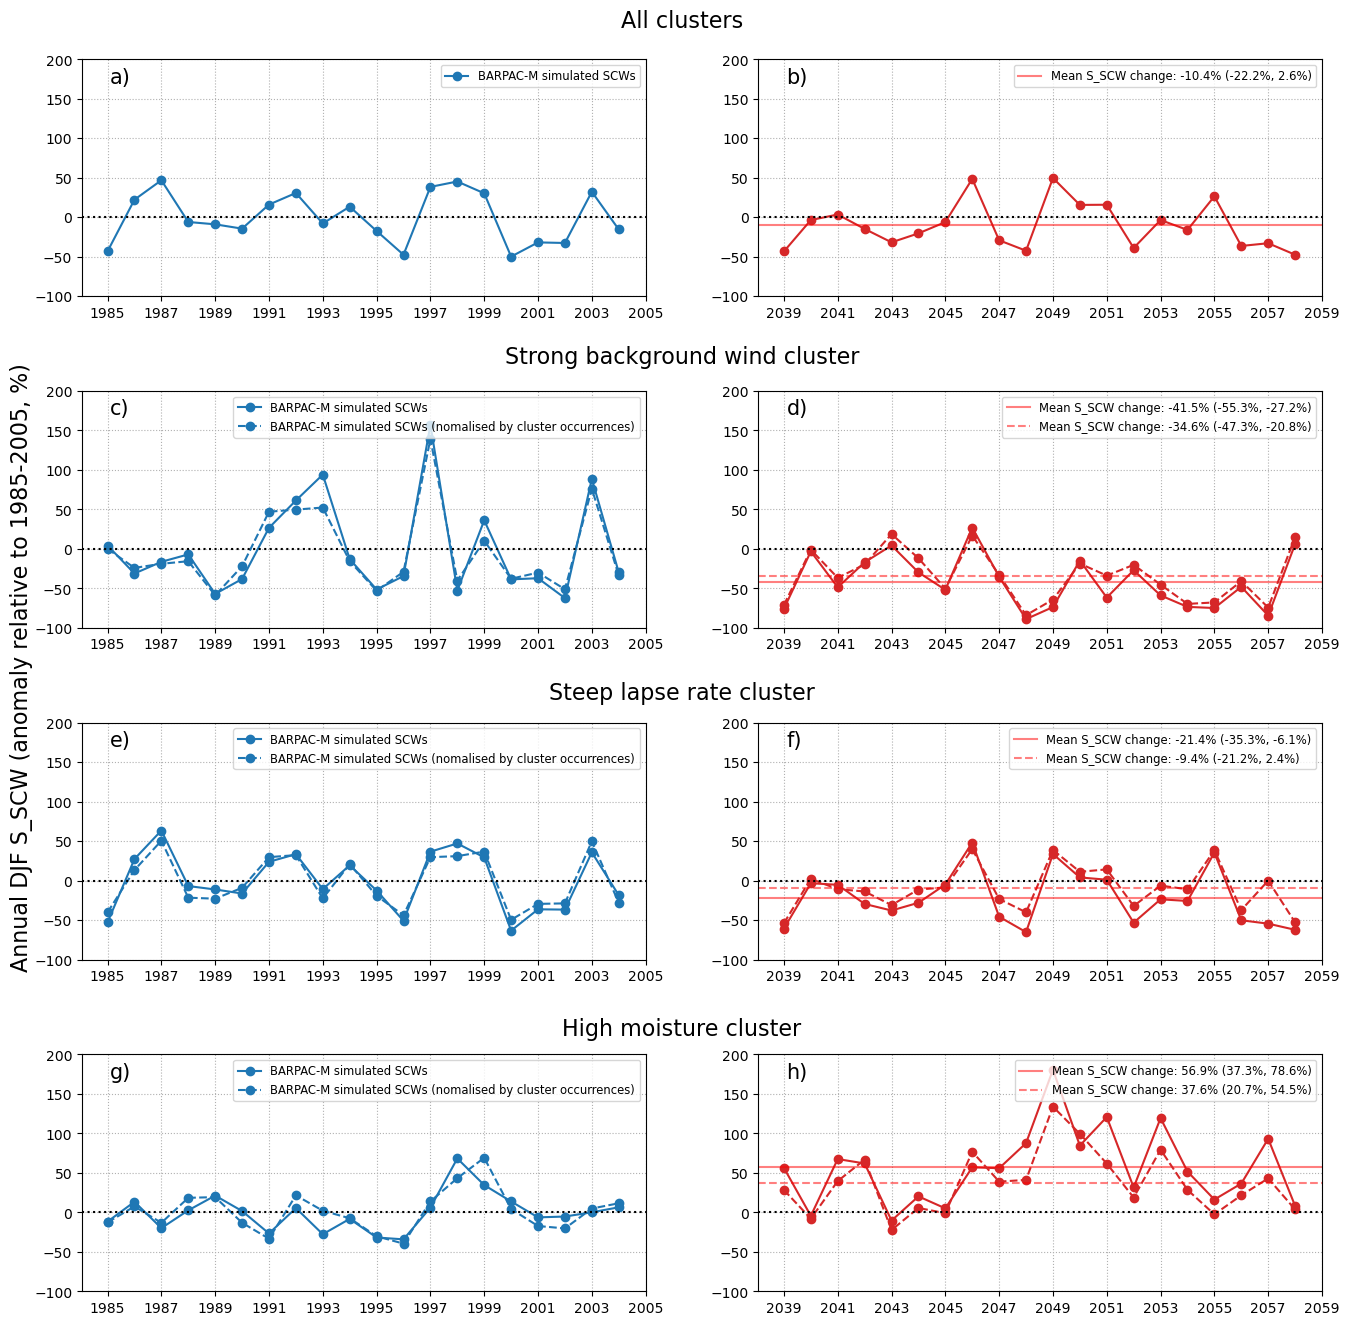

In [9]:
#Same plot as above, but instead of comparing F_ENV and S_SCW, compare S_SCW with S_SCW normalised by the occurrence of each cluster.

def plot_ts(cluster, row, col, p1, p2, cluster_label, letters):   
        
    np.random.seed(0)    
        
    if cluster=="all":
        scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base = \
                    calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster)        
    else:
        scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base, cluster_hist_ts, cluster_rcp_ts, cluster_hist_base = \
                    calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster)
                
    if cluster=="all":
        scw_var="all_events"
        bdsd_var="clusterall_bdsd"
    elif cluster=="0":
        scw_var="cluster0_events"
        bdsd_var="cluster0_bdsd"
        cluster_var="cluster0"        
    elif cluster=="1":
        scw_var="cluster1_events"
        bdsd_var="cluster1_bdsd"      
        cluster_var="cluster1"                
    elif cluster=="2":
        scw_var="cluster2_events"  
        bdsd_var="cluster2_bdsd"      
        cluster_var="cluster2"                
        
    bounds = [str(x)+"%" for x in ((resample_mean(scws_rcp[scw_var]) - scws_hist_base) / scws_hist_base * 100).round(1)]
    scw_label = "Mean S_SCW change: {a}% ({b}, {c})".format(a=np.mean((scws_rcp_ts - scws_hist_base) / scws_hist_base * 100).round(1), b=bounds[0], c=bounds[1])
        
    plt.subplot(row,col,p1)
    plt.plot((scws_hist_ts - scws_hist_base) / scws_hist_base * 100, marker="o", color="tab:blue",ls="-",label="BARPAC-M simulated SCWs")
    if cluster != "all":
        bounds = [str(x)+"%" for x in ((resample_mean(scws_rcp[scw_var],norm=True,norm_da=bdsd_rcp[cluster_var]) - (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100).round(1)]
        scw_norm_label = "Mean S_SCW change: {a}% ({b}, {c})".format(a=np.mean((scws_rcp_ts/cluster_rcp_ts - (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100).round(1), b=bounds[0], c=bounds[1])
        plt.plot(( (scws_hist_ts/cluster_hist_ts) - (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100, marker="o", color="tab:blue",ls="--",label="BARPAC-M simulated SCWs (nomalised by cluster occurrences)")    

    plt.gca().grid(ls=":")
    plt.ylim([-100,200])
    plt.legend(fontsize="small",loc=1)
    plt.gca().axhline(color="k",ls=":") 
    plt.xticks(np.arange(0,21,2),np.arange(1985,2006,2))
    plt.text(0.05,0.9,letters[0]+")",transform=plt.gca().transAxes,size=15)    

    plt.subplot(row,col,p2)
    plt.plot((scws_rcp_ts - scws_hist_base) / scws_hist_base * 100, marker="o", color="tab:red", ls="-")
    
    plt.gca().grid(ls=":")
    plt.gca().axhline(np.mean((scws_rcp_ts - scws_hist_base) / scws_hist_base * 100),color="r", ls="-", label=scw_label, alpha=0.5)
    
    if cluster != "all":
        plt.plot(( (scws_rcp_ts/cluster_rcp_ts) - (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100, marker="o", color="tab:red",ls="--")        
        plt.gca().axhline(np.mean(((scws_rcp_ts/cluster_rcp_ts) - (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100),color="r", ls="--", label=scw_norm_label, alpha=0.5)        


    plt.ylim([-100,200])
    plt.gca().axhline(color="k",ls=":")  
    plt.xticks(np.arange(0,21,2),np.arange(2039,2060,2))    
    plt.legend(fontsize="small",loc=1)
    plt.text(0.05,0.9,letters[1]+")",transform=plt.gca().transAxes,size=15)    

plt.figure(figsize=[16,16])

plot_ts("all", 4, 2, 1, 2, "",["a","b"])
plot_ts("0", 4, 2, 3, 4, "Strong background wind",["c","d"])
plot_ts("1", 4, 2, 5, 6, "Steep lapse rate",["e","f"])
plot_ts("2", 4, 2, 7, 8, "High moisture",["g","h"])

plt.subplots_adjust(hspace=0.4)

plt.gcf().text(0.08,0.5,"Annual DJF S_SCW (anomaly relative to 1985-2005, %)",rotation=90,va="center",size=16) 
plt.gcf().text(0.5,0.9,"All clusters",ha="center",size=16) 
plt.gcf().text(0.5,0.69,"Strong background wind cluster",ha="center",size=16) 
plt.gcf().text(0.5,0.48,"Steep lapse rate cluster",ha="center",size=16) 
plt.gcf().text(0.5,0.27,"High moisture cluster",ha="center",size=16) 

plt.savefig("/g/data/eg3/ab4502/figs/barpa/future_changes_barpacm_sscw.jpeg",dpi=400,bbox_inches="tight")

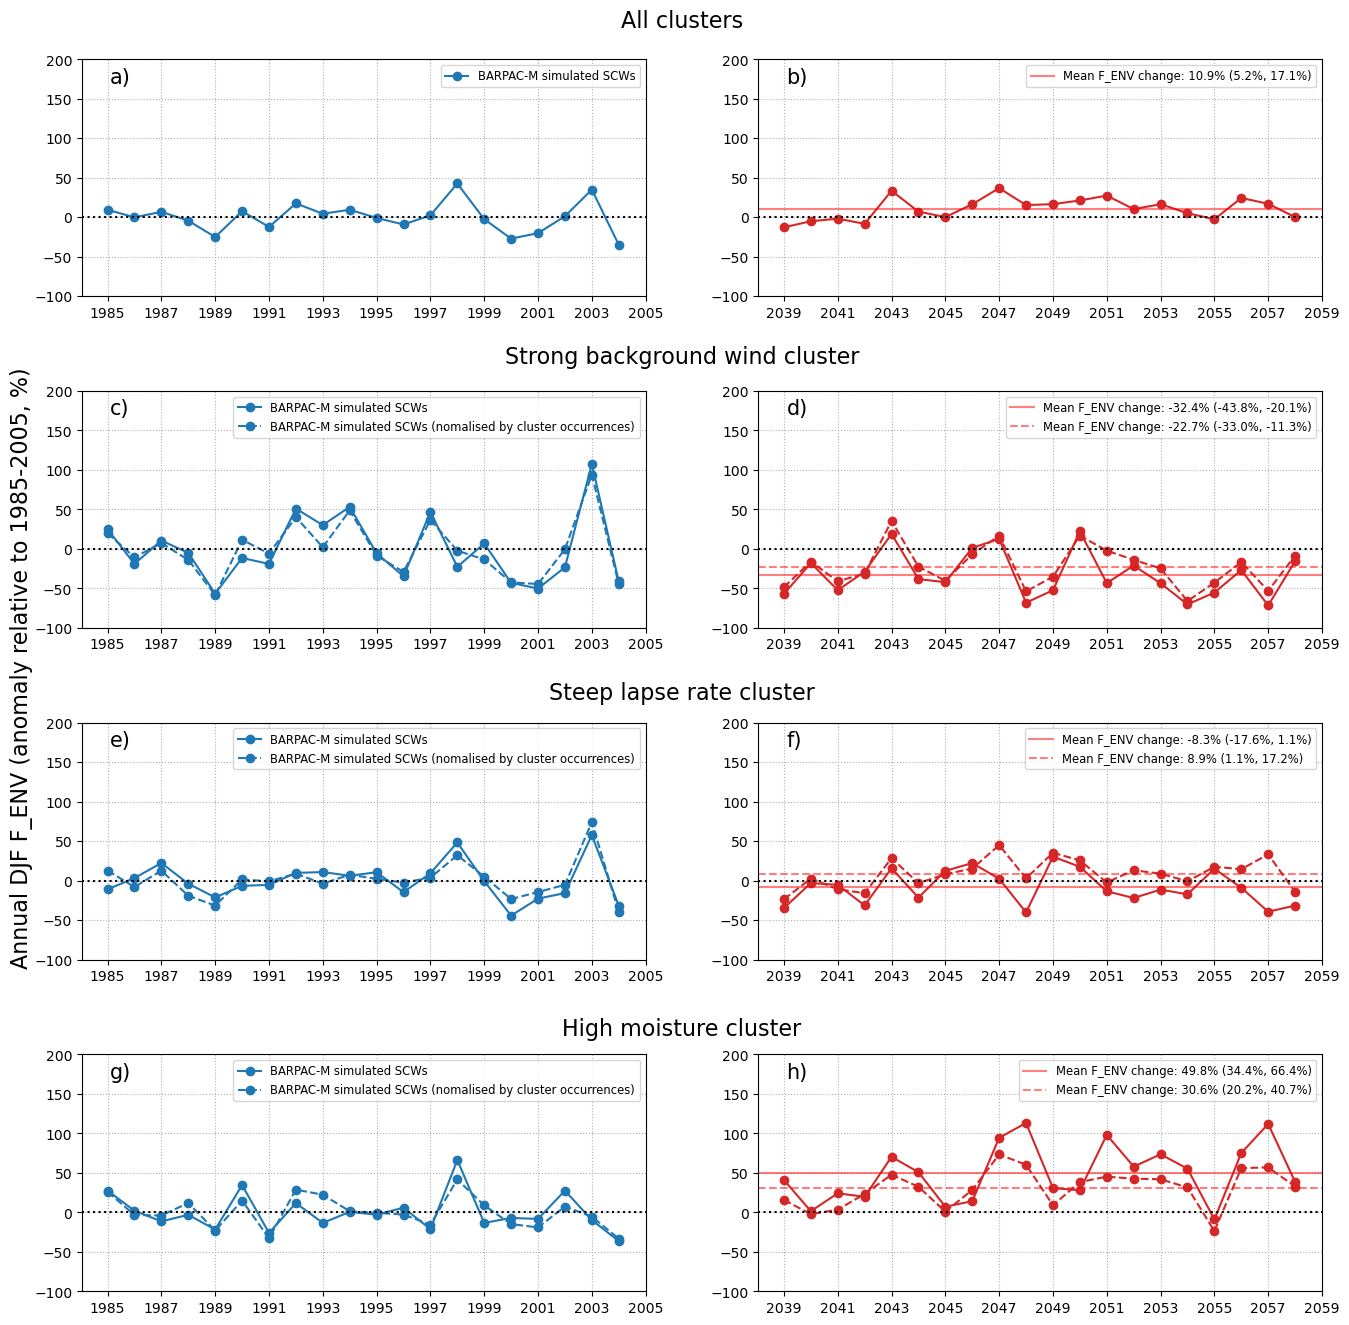

In [10]:
#Same as above, but for F_ENV, and F_ENV normalised by each cluster occurrence

def plot_ts(cluster, row, col, p1, p2, cluster_label, letters):   
        
    np.random.seed(0)    
        
    if cluster=="all":
        scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base = \
                    calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster)        
    else:
        scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base, cluster_hist_ts, cluster_rcp_ts, cluster_hist_base = \
                    calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster)
                
    if cluster=="all":
        scw_var="all_events"
        bdsd_var="clusterall_bdsd"
    elif cluster=="0":
        scw_var="cluster0_events"
        bdsd_var="cluster0_bdsd"
        cluster_var="cluster0"        
    elif cluster=="1":
        scw_var="cluster1_events"
        bdsd_var="cluster1_bdsd"      
        cluster_var="cluster1"                
    elif cluster=="2":
        scw_var="cluster2_events"  
        bdsd_var="cluster2_bdsd"      
        cluster_var="cluster2"                
            
    bounds = [str(x)+"%" for x in ((resample_mean(bdsd_rcp[bdsd_var]) - bdsd_hist_base) / bdsd_hist_base * 100).round(1)]
    bdsd_label = "Mean F_ENV change: {a}% ({b}, {c})".format(a=np.mean((bdsd_rcp_ts - bdsd_hist_base) / bdsd_hist_base * 100).round(1), b=bounds[0], c=bounds[1])
        
    plt.subplot(row,col,p1)
    plt.plot((bdsd_hist_ts - bdsd_hist_base) / bdsd_hist_base * 100, marker="o", color="tab:blue",ls="-",label="BARPAC-M simulated SCWs")
    
    if cluster != "all":
        bounds = [str(x)+"%" for x in (((resample_mean(bdsd_rcp[bdsd_var],norm=True,norm_da=bdsd_rcp[cluster_var])) - (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100).round(1)]
        bdsd_norm_label = "Mean F_ENV change: {a}% ({b}, {c})".format(a=np.mean(((bdsd_rcp_ts/cluster_rcp_ts) - (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100).round(1), b=bounds[0], c=bounds[1])    
        plt.plot(( (bdsd_hist_ts/cluster_hist_ts) - (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100, marker="o", color="tab:blue",ls="--",label="BARPAC-M simulated SCWs (nomalised by cluster occurrences)")            


    plt.gca().grid(ls=":")
    plt.ylim([-100,200])
    plt.legend(fontsize="small",loc=1)
    plt.gca().axhline(color="k",ls=":") 
    plt.xticks(np.arange(0,21,2),np.arange(1985,2006,2))
    plt.text(0.05,0.9,letters[0]+")",transform=plt.gca().transAxes,size=15)    

    plt.subplot(row,col,p2)
    plt.plot((bdsd_rcp_ts - bdsd_hist_base) / bdsd_hist_base * 100, marker="o", color="tab:red", ls="-")

    plt.gca().grid(ls=":")
    plt.gca().axhline(np.mean((bdsd_rcp_ts - bdsd_hist_base) / bdsd_hist_base * 100),color="r", ls="-", label=bdsd_label, alpha=0.5)

    if cluster != "all":
        plt.plot(( (bdsd_rcp_ts/cluster_rcp_ts) - (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100, marker="o", color="tab:red",ls="--")        
        plt.gca().axhline(np.mean(((bdsd_rcp_ts/cluster_rcp_ts) - (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100),color="r", ls="--", label=bdsd_norm_label, alpha=0.5)        

    plt.ylim([-100,200])
    plt.gca().axhline(color="k",ls=":")  
    plt.xticks(np.arange(0,21,2),np.arange(2039,2060,2))    
    plt.legend(fontsize="small",loc=1)
    plt.text(0.05,0.9,letters[1]+")",transform=plt.gca().transAxes,size=15)    

plt.figure(figsize=[16,16])

plot_ts("all", 4, 2, 1, 2, "",["a","b"])
plot_ts("0", 4, 2, 3, 4, "Strong background wind",["c","d"])
plot_ts("1", 4, 2, 5, 6, "Steep lapse rate",["e","f"])
plot_ts("2", 4, 2, 7, 8, "High moisture",["g","h"])

plt.subplots_adjust(hspace=0.4)

plt.gcf().text(0.08,0.5,"Annual DJF F_ENV (anomaly relative to 1985-2005, %)",rotation=90,va="center",size=16) 
plt.gcf().text(0.5,0.9,"All clusters",ha="center",size=16) 
plt.gcf().text(0.5,0.69,"Strong background wind cluster",ha="center",size=16) 
plt.gcf().text(0.5,0.48,"Steep lapse rate cluster",ha="center",size=16) 
plt.gcf().text(0.5,0.27,"High moisture cluster",ha="center",size=16) 

plt.savefig("/g/data/eg3/ab4502/figs/barpa/future_changes_barpacm_fenv.jpeg",dpi=400,bbox_inches="tight")

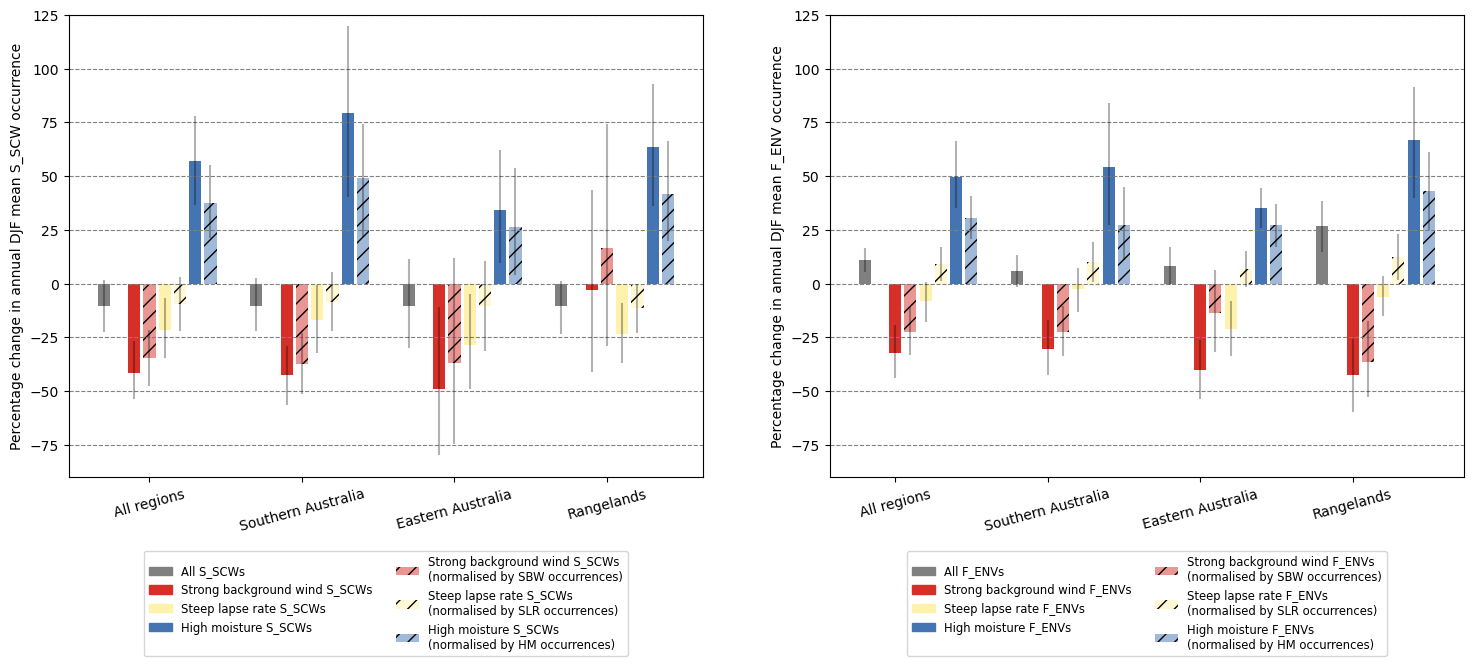

In [11]:
#Calculate mean percentage changes over the domain/time period, in the occurrence of F_ENV and S_SCW for each cluster/NRM region, as well as occurrences normalised by cluster occurrence
scws_mean_changes = []
scws_mean_changes_norm = []
scws_x = []
scws_cols = []
scws_yerr1 = []
scws_yerr2 = []
scws_yerr1_norm = []
scws_yerr2_norm = []

bdsd_mean_changes = []
bdsd_mean_changes_norm = []
bdsd_x = []
bdsd_cols = []
bdsd_yerr1 = []
bdsd_yerr2 = []
bdsd_yerr1_norm = []
bdsd_yerr2_norm = []

cnt = -3

cluster_cols = ["grey",plt.get_cmap("RdYlBu")(0.1),plt.get_cmap("RdYlBu")(0.46),plt.get_cmap("RdYlBu")(0.9)]

for nrm in [0, 3, 2, 1]:
    for cluster, col in zip(["all","0","1","2"], cluster_cols):
        
        if cluster=="all":
            cnt=cnt+3; scws_x.append(cnt)        
        else:
            cnt=cnt+1; scws_x.append(cnt)        
            
        scws_cols.append(col)
        bdsd_cols.append(col)
        
        if cluster=="all": 
            scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base = \
                        calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster, nrm)
        else:
            scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base, cluster_hist_ts, cluster_rcp_ts, cluster_hist_base = \
                        calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster, nrm)           

        scws_mean_changes.append( np.mean((scws_rcp_ts - scws_hist_base) / scws_hist_base * 100) )  
        
        if cluster == "all":
            scws_mean_changes_norm.append(0)
        else:
            scws_mean_changes_norm.append( np.mean(((scws_rcp_ts/cluster_rcp_ts) - (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100) )        
        
        #mean_changes.append( np.mean(scws_rcp_ts - scws_hist_base) )
        cnt=cnt+1; bdsd_x.append(cnt)
        bdsd_mean_changes.append( np.mean((bdsd_rcp_ts - bdsd_hist_base) / bdsd_hist_base * 100) )
        
        if cluster == "all":
            bdsd_mean_changes_norm.append(0)
        else:        
            bdsd_mean_changes_norm.append( np.mean(((bdsd_rcp_ts/cluster_rcp_ts) - (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100) )        
        #mean_changes.append( np.mean(bdsd_rcp_ts - bdsd_hist_base) )          

        if cluster=="all":
            scw_var="all_events"
            bdsd_var="clusterall_bdsd"
        elif cluster=="0":
            scw_var="cluster0_events"
            bdsd_var="cluster0_bdsd"
            cluster_var="cluster0"        
        elif cluster=="1":
            scw_var="cluster1_events"
            bdsd_var="cluster1_bdsd"      
            cluster_var="cluster1"                
        elif cluster=="2":
            scw_var="cluster2_events"  
            bdsd_var="cluster2_bdsd"      
            cluster_var="cluster2"     

        
        if nrm==0:
            a,b = (resample_mean(bdsd_rcp[bdsd_var]) - bdsd_hist_base) / bdsd_hist_base * 100
            bdsd_yerr1.append(a)
            bdsd_yerr2.append(b)

            a,b = (resample_mean(scws_rcp[scw_var]) - scws_hist_base) / scws_hist_base * 100
            scws_yerr1.append(a)
            scws_yerr2.append(b)
            
            if cluster == "all":
                scws_yerr1_norm.append(0)
                scws_yerr2_norm.append(0)      
                bdsd_yerr1_norm.append(0)
                bdsd_yerr2_norm.append(0)                
            else:
                a,b = (resample_mean(scws_rcp[scw_var],norm=True,norm_da=bdsd_rcp[cluster_var]) - (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100
                scws_yerr1_norm.append(a)
                scws_yerr2_norm.append(b)          

                a,b = (resample_mean(bdsd_rcp[bdsd_var],norm=True,norm_da=bdsd_rcp[cluster_var]) - (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100
                bdsd_yerr1_norm.append(a)
                bdsd_yerr2_norm.append(b)            
                        
        else:
            a,b = (resample_mean(xr.where(scws_hist.nrm==nrm,bdsd_rcp[bdsd_var],np.nan)) - bdsd_hist_base) / bdsd_hist_base * 100
            bdsd_yerr1.append(a)
            bdsd_yerr2.append(b)    
            
            a,b = (resample_mean(xr.where(scws_hist.nrm==nrm,scws_rcp[scw_var],np.nan)) - scws_hist_base) / scws_hist_base * 100
            scws_yerr1.append(a)
            scws_yerr2.append(b)                
            
            if cluster == "all":
                scws_yerr1_norm.append(0)
                scws_yerr2_norm.append(0)      
                bdsd_yerr1_norm.append(0)
                bdsd_yerr2_norm.append(0)                
            else:
                a,b = (resample_mean(xr.where(scws_hist.nrm==nrm,bdsd_rcp[bdsd_var],np.nan),norm=True,norm_da=xr.where(scws_hist.nrm==nrm,bdsd_rcp[cluster_var],np.nan)) - \
                       (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100
                bdsd_yerr1_norm.append(a)
                bdsd_yerr2_norm.append(b)
                
                a,b = (resample_mean(xr.where(scws_hist.nrm==nrm,scws_rcp[scw_var],np.nan),norm=True,norm_da=xr.where(scws_hist.nrm==nrm,bdsd_rcp[cluster_var],np.nan)) - \
                       (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100
                scws_yerr1_norm.append(a)
                scws_yerr2_norm.append(b)                          
                
plt.figure(figsize=[18,6])

plt.subplot(1,2,1)
plt.bar(scws_x,scws_mean_changes,color=scws_cols,
        yerr=abs(scws_mean_changes - np.stack([scws_yerr1,scws_yerr2])),error_kw={"alpha":0.3})
plt.bar(np.array(scws_x)+1,scws_mean_changes_norm,color=scws_cols,alpha=0.5,hatch="//",
        yerr=abs(scws_mean_changes_norm - np.stack([scws_yerr1_norm,scws_yerr2_norm])),error_kw={"alpha":0.3})
plt.xticks(np.arange(0,40,10)+3,["All regions","Southern Australia","Eastern Australia","Rangelands"],rotation=15)
plt.ylabel("Percentage change in annual DJF mean S_SCW occurrence")
plt.gca().grid(ls="--",color="grey",axis="y")

labels1 = ["All S_SCWs", "Strong background wind S_SCWs", "Steep lapse rate S_SCWs", "High moisture S_SCWs"]
labels2 = ["Strong background wind S_SCWs\n(normalised by SBW occurrences)",
           "Steep lapse rate S_SCWs\n(normalised by SLR occurrences)",
           "High moisture S_SCWs\n(normalised by HM occurrences)"]
handles1 = [plt.Rectangle((0,0),1,1,color=c,label=l) for c, l in zip(scws_cols[0:4], labels1)]
handles2 = [plt.Rectangle((0,0),1,1,fc=c,label=l,alpha=0.5,hatch="//") for c, l in zip(scws_cols[1:4], labels2)]
plt.legend(handles1+handles2,labels1+labels2,loc=8,bbox_to_anchor=(0.5,-0.4),ncols=2,fontsize="small")
plt.ylim([-90,125])

plt.subplot(1,2,2)
plt.bar(bdsd_x,bdsd_mean_changes,color=bdsd_cols,
        yerr=abs(bdsd_mean_changes - np.stack([bdsd_yerr1,bdsd_yerr2])),error_kw={"alpha":0.3})
plt.bar(np.array(bdsd_x)+1,bdsd_mean_changes_norm,color=bdsd_cols,alpha=0.5,hatch="//",
        yerr=abs(bdsd_mean_changes_norm - np.stack([bdsd_yerr1_norm,bdsd_yerr2_norm])),error_kw={"alpha":0.3})
plt.xticks(np.arange(0,40,10)+3,["All regions","Southern Australia","Eastern Australia","Rangelands"],rotation=15);          
plt.ylabel("Percentage change in annual DJF mean F_ENV occurrence")
plt.gca().grid(ls="--",color="grey",axis="y")
labels1 = ["All F_ENVs", "Strong background wind F_ENVs", "Steep lapse rate F_ENVs", "High moisture F_ENVs"]
labels2 = ["Strong background wind F_ENVs\n(normalised by SBW occurrences)",
           "Steep lapse rate F_ENVs\n(normalised by SLR occurrences)",
           "High moisture F_ENVs\n(normalised by HM occurrences)"]
handles1 = [plt.Rectangle((0,0),1,1,color=c,label=l) for c, l in zip(scws_cols[0:4], labels1)]
handles2 = [plt.Rectangle((0,0),1,1,fc=c,label=l,alpha=0.5,hatch="//") for c, l in zip(scws_cols[1:4], labels2)]
plt.legend(handles1+handles2,labels1+labels2,loc=8,bbox_to_anchor=(0.5,-0.4),ncols=2,fontsize="small")
plt.ylim([-90,125])

plt.savefig("/g/data/eg3/ab4502/figs/barpa/future_mean_prob_anom_changes_barpacm_nrm.jpeg",dpi=400,bbox_inches="tight")                

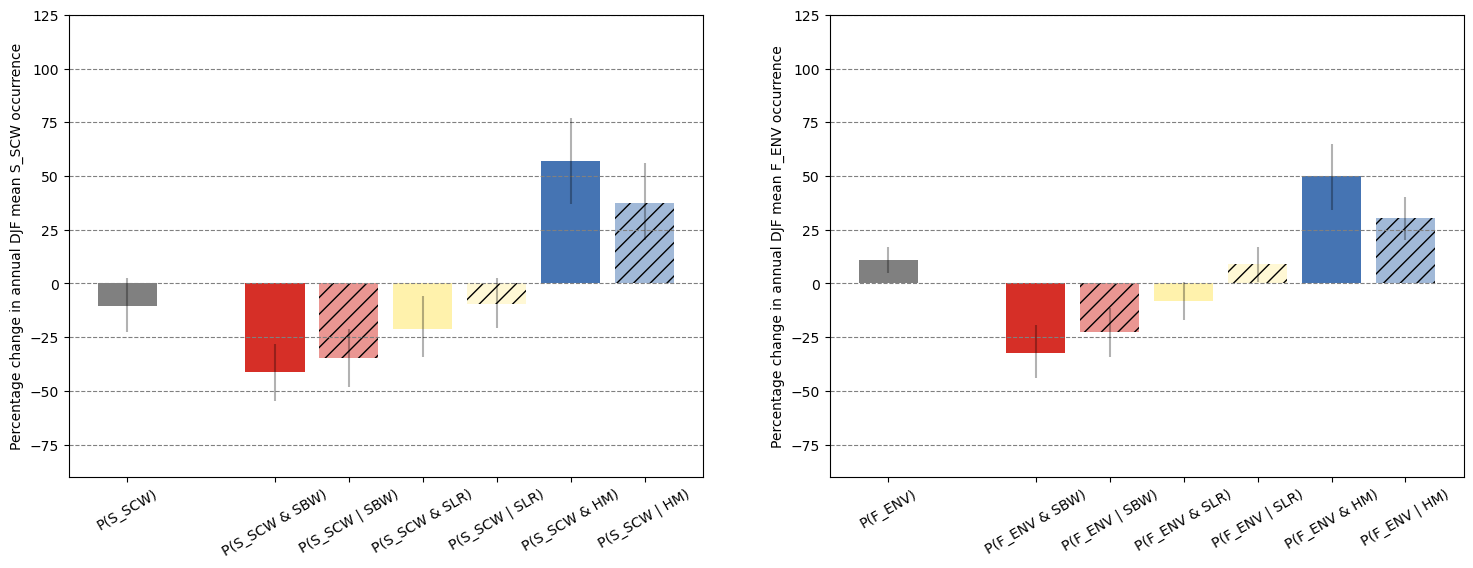

In [12]:
#Calculate mean percentage changes over the domain/time period, in the occurrence of F_ENV and S_SCW for each cluster/NRM region, as well as occurrences normalised by cluster occurrence
scws_mean_changes = []
scws_mean_changes_norm = []
scws_x = []
scws_cols = []
scws_yerr1 = []
scws_yerr2 = []
scws_yerr1_norm = []
scws_yerr2_norm = []

bdsd_mean_changes = []
bdsd_mean_changes_norm = []
bdsd_x = []
bdsd_cols = []
bdsd_yerr1 = []
bdsd_yerr2 = []
bdsd_yerr1_norm = []
bdsd_yerr2_norm = []

cnt = -3

cluster_cols = ["grey",plt.get_cmap("RdYlBu")(0.1),plt.get_cmap("RdYlBu")(0.46),plt.get_cmap("RdYlBu")(0.9)]

for nrm in [0]:
    for cluster, col in zip(["all","0","1","2"], cluster_cols):
        
        if cluster=="all":
            cnt=cnt+3; scws_x.append(cnt)        
        else:
            cnt=cnt+1; scws_x.append(cnt)        
            
        scws_cols.append(col)
        bdsd_cols.append(col)
        
        if cluster=="all": 
            scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base = \
                        calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster, nrm)
        else:
            scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base, cluster_hist_ts, cluster_rcp_ts, cluster_hist_base = \
                        calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster, nrm)           

        scws_mean_changes.append( np.mean((scws_rcp_ts - scws_hist_base) / scws_hist_base * 100) )  
        
        if cluster == "all":
            scws_mean_changes_norm.append(0)
        else:
            scws_mean_changes_norm.append( np.mean(((scws_rcp_ts/cluster_rcp_ts) - (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100) )        
        
        #mean_changes.append( np.mean(scws_rcp_ts - scws_hist_base) )
        cnt=cnt+1; bdsd_x.append(cnt)
        bdsd_mean_changes.append( np.mean((bdsd_rcp_ts - bdsd_hist_base) / bdsd_hist_base * 100) )
        
        if cluster == "all":
            bdsd_mean_changes_norm.append(0)
        else:        
            bdsd_mean_changes_norm.append( np.mean(((bdsd_rcp_ts/cluster_rcp_ts) - (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100) )        
        #mean_changes.append( np.mean(bdsd_rcp_ts - bdsd_hist_base) )          

        if cluster=="all":
            scw_var="all_events"
            bdsd_var="clusterall_bdsd"
        elif cluster=="0":
            scw_var="cluster0_events"
            bdsd_var="cluster0_bdsd"
            cluster_var="cluster0"        
        elif cluster=="1":
            scw_var="cluster1_events"
            bdsd_var="cluster1_bdsd"      
            cluster_var="cluster1"                
        elif cluster=="2":
            scw_var="cluster2_events"  
            bdsd_var="cluster2_bdsd"      
            cluster_var="cluster2"     

        
        if nrm==0:
            a,b = (resample_mean(bdsd_rcp[bdsd_var]) - bdsd_hist_base) / bdsd_hist_base * 100
            bdsd_yerr1.append(a)
            bdsd_yerr2.append(b)

            a,b = (resample_mean(scws_rcp[scw_var]) - scws_hist_base) / scws_hist_base * 100
            scws_yerr1.append(a)
            scws_yerr2.append(b)
            
            if cluster == "all":
                scws_yerr1_norm.append(0)
                scws_yerr2_norm.append(0)      
                bdsd_yerr1_norm.append(0)
                bdsd_yerr2_norm.append(0)                
            else:
                a,b = (resample_mean(scws_rcp[scw_var],norm=True,norm_da=bdsd_rcp[cluster_var]) - (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100
                scws_yerr1_norm.append(a)
                scws_yerr2_norm.append(b)          

                a,b = (resample_mean(bdsd_rcp[bdsd_var],norm=True,norm_da=bdsd_rcp[cluster_var]) - (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100
                bdsd_yerr1_norm.append(a)
                bdsd_yerr2_norm.append(b)            
                        
        else:
            a,b = (resample_mean(xr.where(scws_hist.nrm==nrm,bdsd_rcp[bdsd_var],np.nan)) - bdsd_hist_base) / bdsd_hist_base * 100
            bdsd_yerr1.append(a)
            bdsd_yerr2.append(b)    
            
            a,b = (resample_mean(xr.where(scws_hist.nrm==nrm,scws_rcp[scw_var],np.nan)) - scws_hist_base) / scws_hist_base * 100
            scws_yerr1.append(a)
            scws_yerr2.append(b)                
            
            if cluster == "all":
                scws_yerr1_norm.append(0)
                scws_yerr2_norm.append(0)      
                bdsd_yerr1_norm.append(0)
                bdsd_yerr2_norm.append(0)                
            else:
                a,b = (resample_mean(xr.where(scws_hist.nrm==nrm,bdsd_rcp[bdsd_var],np.nan),norm=True,norm_da=xr.where(scws_hist.nrm==nrm,bdsd_rcp[cluster_var],np.nan)) - \
                       (bdsd_hist_base/cluster_hist_base)) / (bdsd_hist_base/cluster_hist_base) * 100
                bdsd_yerr1_norm.append(a)
                bdsd_yerr2_norm.append(b)
                
                a,b = (resample_mean(xr.where(scws_hist.nrm==nrm,scws_rcp[scw_var],np.nan),norm=True,norm_da=xr.where(scws_hist.nrm==nrm,bdsd_rcp[cluster_var],np.nan)) - \
                       (scws_hist_base/cluster_hist_base)) / (scws_hist_base/cluster_hist_base) * 100
                scws_yerr1_norm.append(a)
                scws_yerr2_norm.append(b)                          
                
plt.figure(figsize=[18,6])

plt.subplot(1,2,1)
plt.bar(scws_x,scws_mean_changes,color=scws_cols,
        yerr=abs(scws_mean_changes - np.stack([scws_yerr1,scws_yerr2])),error_kw={"alpha":0.3})
plt.bar(np.array(scws_x)+1,scws_mean_changes_norm,color=scws_cols,alpha=0.5,hatch="//",
        yerr=abs(scws_mean_changes_norm - np.stack([scws_yerr1_norm,scws_yerr2_norm])),error_kw={"alpha":0.3})
plt.ylabel("Percentage change in annual DJF mean S_SCW occurrence")
plt.gca().grid(ls="--",color="grey",axis="y")
labels1 = ["P(S_SCW)", "P(S_SCW & SBW)", "P(S_SCW | SBW)", "P(S_SCW & SLR)", "P(S_SCW | SLR)", "P(S_SCW & HM)", "P(S_SCW | HM)"]
plt.xticks([0,2,3,4,5,6,7],labels1,rotation=30)
plt.ylim([-90,125])

plt.subplot(1,2,2)
plt.bar(bdsd_x,bdsd_mean_changes,color=bdsd_cols,
        yerr=abs(bdsd_mean_changes - np.stack([bdsd_yerr1,bdsd_yerr2])),error_kw={"alpha":0.3})
plt.bar(np.array(bdsd_x)+1,bdsd_mean_changes_norm,color=bdsd_cols,alpha=0.5,hatch="//",
        yerr=abs(bdsd_mean_changes_norm - np.stack([bdsd_yerr1_norm,bdsd_yerr2_norm])),error_kw={"alpha":0.3})
plt.ylabel("Percentage change in annual DJF mean F_ENV occurrence")
plt.gca().grid(ls="--",color="grey",axis="y")
labels1 = ["P(F_ENV)", "P(F_ENV & SBW)", "P(F_ENV | SBW)", "P(F_ENV & SLR)", "P(F_ENV | SLR)", "P(F_ENV & HM)", "P(F_ENV | HM)"]
plt.xticks([1,3,4,5,6,7,8],labels1,rotation=30)
plt.ylim([-90,125])

plt.savefig("/g/data/eg3/ab4502/figs/barpa/future_mean_prob_anom_changes_barpacm.jpeg",dpi=400,bbox_inches="tight")                

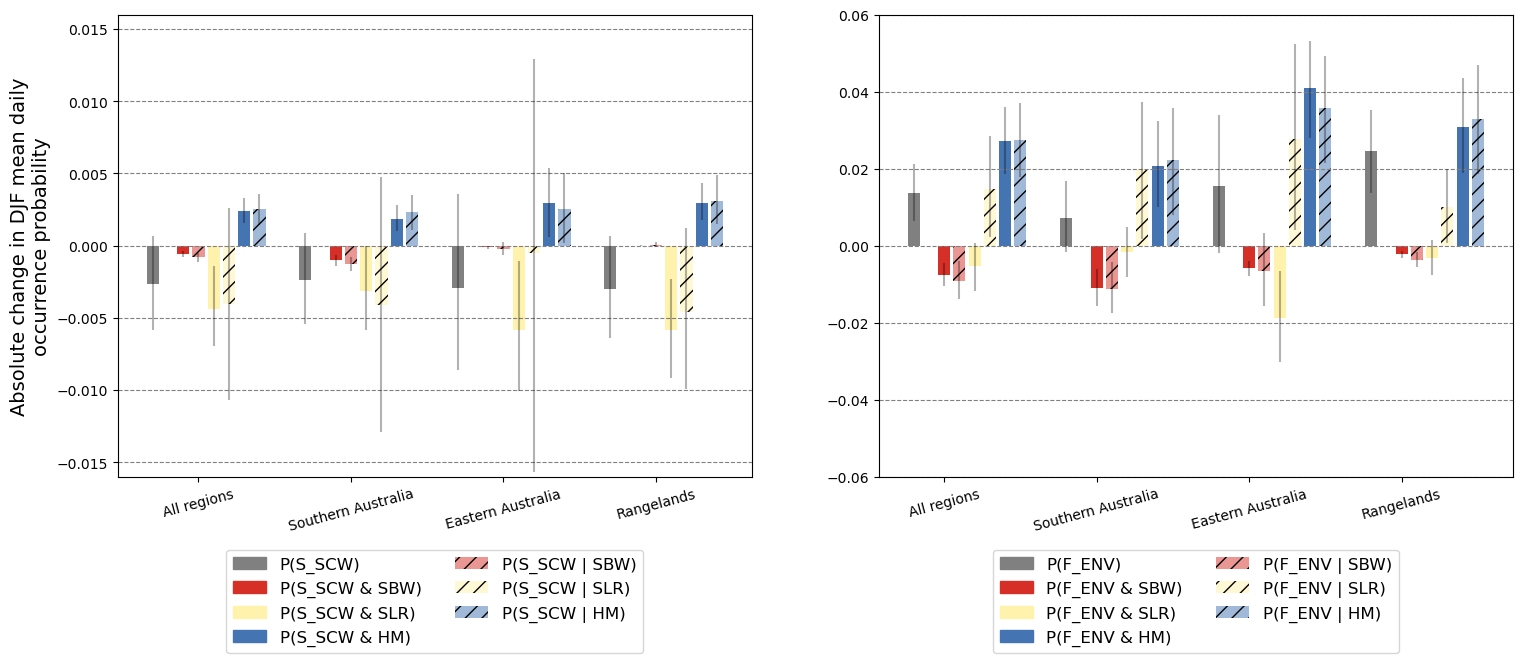

In [13]:
#Calculate change in mean probability over the domain, for each cluster/NRM region, as well as change in mean conditional probability

scws_mean_changes = []
scws_mean_changes_norm = []
scws_x = []
scws_cols = []
scws_yerr1 = []
scws_yerr2 = []
scws_yerr1_norm = []
scws_yerr2_norm = []

bdsd_mean_changes = []
bdsd_mean_changes_norm = []
bdsd_x = []
bdsd_cols = []
bdsd_yerr1 = []
bdsd_yerr2 = []
bdsd_yerr1_norm = []
bdsd_yerr2_norm = []

cnt = -3

days_hist = len(scws_hist.attrs["daily_time"])
days_rcp = len(scws_rcp.attrs["daily_time"])

cluster_cols = ["grey",plt.get_cmap("RdYlBu")(0.1),plt.get_cmap("RdYlBu")(0.46),plt.get_cmap("RdYlBu")(0.9)]

#For each NRM region (all, south, east, rangelands)
for nrm in [0, 3, 2, 1]:
    
    #First, load in the land sea mask, and get the number of spatial points used in the region (lsm_count). This is used to calculate the mean daily probability accross all spatial points
    if nrm==0:
        lsm_count = lsm.lnd_mask.values.sum()
    else:
        lsm_count = xr.where(scws_hist.nrm==nrm,lsm.lnd_mask,0).values.sum()
        
    #For each environmental cluster
    for cluster, col in zip(["all","0","1","2"], cluster_cols):
        
        #Store some counts for plotting purposes
        if cluster=="all":
            cnt=cnt+3; scws_x.append(cnt)        
        else:
            cnt=cnt+1; scws_x.append(cnt)        
        
        #Store some colours for plotting
        scws_cols.append(col)
        bdsd_cols.append(col)
        
        #Get annual DJF counts of S_SCWs and F_ENVs for the historical and future periods, as well as the base mean, for the current NRM region
        #If it's just for one cluster, then also get the annual DJF counts of total cluster occurrences
        if cluster=="all": 
            scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base = \
                        calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster, nrm)
        else:
            scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base, cluster_hist_ts, cluster_rcp_ts, cluster_hist_base = \
                        calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster, nrm)           

        #Kepp track of the change in mean S_SCW probability
        scws_mean_changes.append( (np.sum(scws_rcp_ts) / (lsm_count * days_rcp)) - (np.sum(scws_hist_ts) / (lsm_count * days_hist)) )  
        
        #Keep track of the change in mean S_SCW probability condiitonal on the occurrence for the current cluster
        if cluster == "all":
            scws_mean_changes_norm.append(0)
        else:
            p1_hist_scw = (np.sum(scws_hist_ts)) / (lsm_count * days_hist)            
            p2_hist = (np.sum(cluster_hist_ts)) / (lsm_count * days_hist)            
            p1_rcp_scw = (np.sum(scws_rcp_ts)) / (lsm_count * days_rcp)
            p2_rcp = (np.sum(cluster_rcp_ts)) / (lsm_count * days_rcp)                        
            scws_mean_changes_norm.append( (p1_rcp_scw/p2_rcp) - (p1_hist_scw/p2_hist) )        
        
        #Do the same for F_ENVs
        cnt=cnt+1; bdsd_x.append(cnt)
        bdsd_mean_changes.append( (np.sum(bdsd_rcp_ts) / (lsm_count * days_rcp)) - (np.sum(bdsd_hist_ts) / (lsm_count * days_hist)) )  
        
        if cluster == "all":
            bdsd_mean_changes_norm.append(0)
        else:        
            p1_hist_bdsd = (np.sum(bdsd_hist_ts)) / (lsm_count * days_hist)
            p1_rcp_bdsd = (np.sum(bdsd_rcp_ts)) / (lsm_count * days_rcp)
            bdsd_mean_changes_norm.append( (p1_rcp_bdsd/p2_rcp) - (p1_hist_bdsd/p2_hist) )        

        
        #Define some variable names, as now we have to go back in to the xarray datasets to resample the datasets (for statistical testing)
        if cluster=="all":
            scw_var="all_events"
            bdsd_var="clusterall_bdsd"
        elif cluster=="0":
            scw_var="cluster0_events"
            bdsd_var="cluster0_bdsd"
            cluster_var="cluster0"        
        elif cluster=="1":
            scw_var="cluster1_events"
            bdsd_var="cluster1_bdsd"      
            cluster_var="cluster1"                
        elif cluster=="2":
            scw_var="cluster2_events"  
            bdsd_var="cluster2_bdsd"      
            cluster_var="cluster2"     

        if nrm==0:
            
            #For all NRM regions, resample the annual mean F_ENV probability over all spatial points, and calculate upper and lower uncertainty bounds on the change 
            # relative to the historical period
            a,b = resample_mean_prob(bdsd_rcp[bdsd_var], days_rcp, lsm_count) -\
                        (np.sum(bdsd_hist_ts) / (lsm_count * days_hist))
            bdsd_yerr1.append(a)
            bdsd_yerr2.append(b)
            
            #Do the same for S_SCWs
            a,b = resample_mean_prob(scws_rcp[scw_var], days_rcp, lsm_count) -\
                        (np.sum(scws_hist_ts) / (lsm_count * days_hist))            
            scws_yerr1.append(a)
            scws_yerr2.append(b)     
            
            if cluster != "all":
                
                #Now if resampling for a single cluster, we can also resample the change in conditional probability of F_ENV
                a,b = resample_mean_prob(bdsd_rcp[bdsd_var], days_rcp, lsm_count, cond=True, cond_da=bdsd_rcp[cluster_var]) -\
                            (p1_hist_bdsd/p2_hist)
                bdsd_yerr1_norm.append(a)
                bdsd_yerr2_norm.append(b)

                #Same for the S_SCWs
                a,b = resample_mean_prob(scws_rcp[scw_var], days_rcp, lsm_count, cond=True, cond_da=bdsd_rcp[cluster_var]) -\
                            (p1_hist_scw/p2_hist)
                scws_yerr1_norm.append(a)
                scws_yerr2_norm.append(b)           
                
            else:
                
                #If we are currently looking at all clusters, then there is no conditional probabilities calculated, so just append zeros
                
                bdsd_yerr1_norm.append(0)
                bdsd_yerr2_norm.append(0)

                scws_yerr1_norm.append(0)
                scws_yerr2_norm.append(0)                           
            
        else:
            
            #Finally, if we are focussing on one NRM region, we have to mask that region first, before passing F_ENVs to resample function
            a,b = resample_mean_prob(xr.where(scws_hist.nrm==nrm,bdsd_rcp[bdsd_var],np.nan), days_rcp, lsm_count) -\
                        (np.sum(bdsd_hist_ts) / (lsm_count * days_hist))
            bdsd_yerr1.append(a)
            bdsd_yerr2.append(b)
            
            #Same bur for S_SCWs
            a,b = resample_mean_prob(xr.where(scws_hist.nrm==nrm,scws_rcp[scw_var],np.nan), days_rcp, lsm_count) -\
                        (np.sum(scws_hist_ts) / (lsm_count * days_hist)) 
            scws_yerr1.append(a)
            scws_yerr2.append(b)   
            
            if cluster != "all":
                
                #Same but for conditional probabilities
                a,b = resample_mean_prob(xr.where(scws_hist.nrm==nrm,bdsd_rcp[bdsd_var],np.nan), days_rcp, lsm_count, cond=True, cond_da=xr.where(scws_hist.nrm==nrm,bdsd_rcp[cluster_var],np.nan)) -\
                            (p1_hist_bdsd/p2_hist)
                bdsd_yerr1_norm.append(a)
                bdsd_yerr2_norm.append(b)

                a,b = resample_mean_prob(xr.where(scws_hist.nrm==nrm,scws_rcp[scw_var],np.nan), days_rcp, lsm_count, cond=True, cond_da=xr.where(scws_hist.nrm==nrm,bdsd_rcp[cluster_var],np.nan)) -\
                            (p1_hist_scw/p2_hist)
                scws_yerr1_norm.append(a)
                scws_yerr2_norm.append(b)
                                
            else:
                
                bdsd_yerr1_norm.append(0)
                bdsd_yerr2_norm.append(0)

                scws_yerr1_norm.append(0)
                scws_yerr2_norm.append(0)                     
       
plt.figure(figsize=[18,6])

plt.subplot(1,2,1)

#Plot mean P(S_SCW) changes for each NRM region and cluster, with error bars
plt.bar(scws_x,scws_mean_changes,color=scws_cols,
        yerr=abs(scws_mean_changes - np.stack([scws_yerr1,scws_yerr2])),error_kw={"alpha":0.3})
#Plot mean P(S_SCW | Cluster) changes
plt.bar(np.array(scws_x)+1,scws_mean_changes_norm,color=scws_cols,alpha=0.5,hatch="//",
       yerr=abs(scws_mean_changes_norm - np.stack([scws_yerr1_norm,scws_yerr2_norm])),error_kw={"alpha":0.3})
plt.xticks(np.arange(0,40,10)+3,["All regions","Southern Australia","Eastern Australia","Rangelands"],rotation=15)
plt.ylabel("Absolute change in DJF mean daily\noccurrence probability",size=14)
plt.gca().grid(ls="--",color="grey",axis="y")
labels1 = ["P(S_SCW)", "P(S_SCW & SBW)", "P(S_SCW & SLR)", "P(S_SCW & HM)"]
labels2 = ["P(S_SCW | SBW)", "P(S_SCW | SLR)", "P(S_SCW | HM)"]
handles1 = [plt.Rectangle((0,0),1,1,color=c,label=l) for c, l in zip(scws_cols[0:4], labels1)]
handles2 = [plt.Rectangle((0,0),1,1,fc=c,label=l,alpha=0.5,hatch="//") for c, l in zip(scws_cols[1:4], labels2)]
plt.legend(handles1+handles2,labels1+labels2,loc=8,bbox_to_anchor=(0.5,-0.4),ncols=2,fontsize="large")
plt.ylim([-0.016,0.016])

plt.subplot(1,2,2)
plt.bar(bdsd_x,bdsd_mean_changes,color=bdsd_cols,
        yerr=abs(bdsd_mean_changes - np.stack([bdsd_yerr1,bdsd_yerr2])),error_kw={"alpha":0.3})
plt.bar(np.array(bdsd_x)+1,bdsd_mean_changes_norm,color=scws_cols,alpha=0.5,hatch="//",
        yerr=abs(bdsd_mean_changes_norm - np.stack([bdsd_yerr1_norm,bdsd_yerr2_norm])),error_kw={"alpha":0.3})
plt.xticks(np.arange(0,40,10)+3,["All regions","Southern Australia","Eastern Australia","Rangelands"],rotation=15);                        
plt.gca().grid(ls="--",color="grey",axis="y")    
labels1 = ["P(F_ENV)", "P(F_ENV & SBW)", "P(F_ENV & SLR)", "P(F_ENV & HM)"]
labels2 = ["P(F_ENV | SBW)", "P(F_ENV | SLR)", "P(F_ENV | HM)"]
handles1 = [plt.Rectangle((0,0),1,1,color=c,label=l) for c, l in zip(scws_cols[0:4], labels1)]
handles2 = [plt.Rectangle((0,0),1,1,fc=c,label=l,alpha=0.5,hatch="//") for c, l in zip(scws_cols[1:4], labels2)]
plt.legend(handles1+handles2,labels1+labels2,loc=8,bbox_to_anchor=(0.5,-0.4),ncols=2,fontsize="large")
plt.ylim([-0.06,0.06])

plt.savefig("/g/data/eg3/ab4502/figs/barpa/future_mean_prob_changes_barpacm_nrm.jpeg",dpi=400,bbox_inches="tight")  

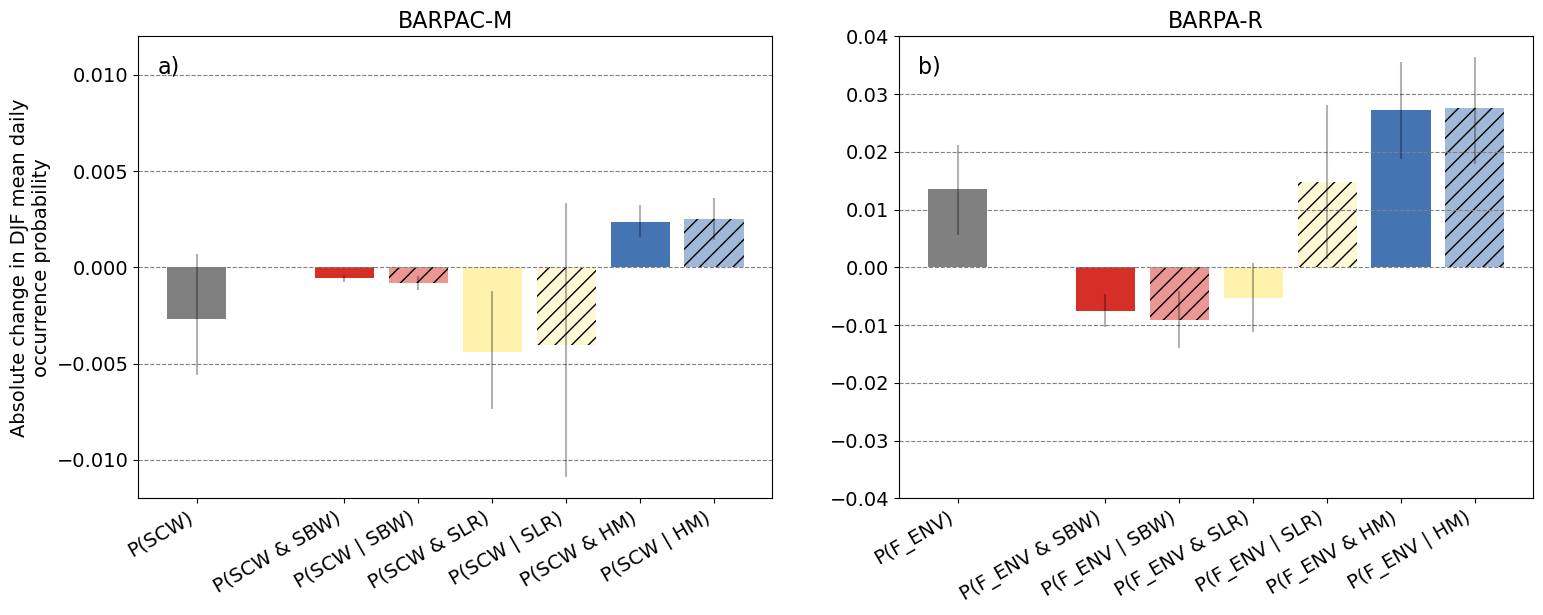

In [22]:
#Calculate change in mean probability over the domain, for each cluster/NRM region, as well as change in mean conditional probability

scws_mean_changes = []
scws_mean_changes_norm = []
scws_x = []
scws_cols = []
scws_yerr1 = []
scws_yerr2 = []
scws_yerr1_norm = []
scws_yerr2_norm = []

bdsd_mean_changes = []
bdsd_mean_changes_norm = []
bdsd_x = []
bdsd_cols = []
bdsd_yerr1 = []
bdsd_yerr2 = []
bdsd_yerr1_norm = []
bdsd_yerr2_norm = []

cnt = -3

days_hist = len(scws_hist.attrs["daily_time"])
days_rcp = len(scws_rcp.attrs["daily_time"])

cluster_cols = ["grey",plt.get_cmap("RdYlBu")(0.1),plt.get_cmap("RdYlBu")(0.46),plt.get_cmap("RdYlBu")(0.9)]

#For each NRM region (all, south, east, rangelands)
for nrm in [0]:
    
    #First, load in the land sea mask, and get the number of spatial points used in the region (lsm_count). This is used to calculate the mean daily probability accross all spatial points
    if nrm==0:
        lsm_count = lsm.lnd_mask.values.sum()
    else:
        lsm_count = xr.where(scws_hist.nrm==nrm,lsm.lnd_mask,0).values.sum()
        
    #For each environmental cluster
    for cluster, col in zip(["all","0","1","2"], cluster_cols):
        
        #Store some counts for plotting purposes
        if cluster=="all":
            cnt=cnt+3; scws_x.append(cnt)        
        else:
            cnt=cnt+1; scws_x.append(cnt)        
        
        #Store some colours for plotting
        scws_cols.append(col)
        bdsd_cols.append(col)
        
        #Get annual DJF counts of S_SCWs and F_ENVs for the historical and future periods, as well as the base mean, for the current NRM region
        #If it's just for one cluster, then also get the annual DJF counts of total cluster occurrences
        if cluster=="all": 
            scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base = \
                        calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster, nrm)
        else:
            scws_hist_ts, scws_rcp_ts, scws_hist_base, bdsd_hist_ts, bdsd_rcp_ts, bdsd_hist_base, cluster_hist_ts, cluster_rcp_ts, cluster_hist_base = \
                        calc_mean_change(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, cluster, nrm)           

        #Kepp track of the change in mean S_SCW probability
        scws_mean_changes.append( (np.sum(scws_rcp_ts) / (lsm_count * days_rcp)) - (np.sum(scws_hist_ts) / (lsm_count * days_hist)) )  
        
        #Keep track of the change in mean S_SCW probability condiitonal on the occurrence for the current cluster
        if cluster == "all":
            scws_mean_changes_norm.append(0)
        else:
            p1_hist_scw = (np.sum(scws_hist_ts)) / (lsm_count * days_hist)            
            p2_hist = (np.sum(cluster_hist_ts)) / (lsm_count * days_hist)            
            p1_rcp_scw = (np.sum(scws_rcp_ts)) / (lsm_count * days_rcp)
            p2_rcp = (np.sum(cluster_rcp_ts)) / (lsm_count * days_rcp)                        
            scws_mean_changes_norm.append( (p1_rcp_scw/p2_rcp) - (p1_hist_scw/p2_hist) )        
        
        #Do the same for F_ENVs
        cnt=cnt+1; bdsd_x.append(cnt)
        bdsd_mean_changes.append( (np.sum(bdsd_rcp_ts) / (lsm_count * days_rcp)) - (np.sum(bdsd_hist_ts) / (lsm_count * days_hist)) )  
        
        if cluster == "all":
            bdsd_mean_changes_norm.append(0)
        else:        
            p1_hist_bdsd = (np.sum(bdsd_hist_ts)) / (lsm_count * days_hist)
            p1_rcp_bdsd = (np.sum(bdsd_rcp_ts)) / (lsm_count * days_rcp)
            bdsd_mean_changes_norm.append( (p1_rcp_bdsd/p2_rcp) - (p1_hist_bdsd/p2_hist) )        

        
        #Define some variable names, as now we have to go back in to the xarray datasets to resample the datasets (for statistical testing)
        if cluster=="all":
            scw_var="all_events"
            bdsd_var="clusterall_bdsd"
        elif cluster=="0":
            scw_var="cluster0_events"
            bdsd_var="cluster0_bdsd"
            cluster_var="cluster0"        
        elif cluster=="1":
            scw_var="cluster1_events"
            bdsd_var="cluster1_bdsd"      
            cluster_var="cluster1"                
        elif cluster=="2":
            scw_var="cluster2_events"  
            bdsd_var="cluster2_bdsd"      
            cluster_var="cluster2"     

        if nrm==0:
            
            #For all NRM regions, resample the annual mean F_ENV probability over all spatial points, and calculate upper and lower uncertainty bounds on the change 
            # relative to the historical period
            a,b = resample_mean_prob(bdsd_rcp[bdsd_var], days_rcp, lsm_count) -\
                        (np.sum(bdsd_hist_ts) / (lsm_count * days_hist))
            bdsd_yerr1.append(a)
            bdsd_yerr2.append(b)
            
            #Do the same for S_SCWs
            a,b = resample_mean_prob(scws_rcp[scw_var], days_rcp, lsm_count) -\
                        (np.sum(scws_hist_ts) / (lsm_count * days_hist))            
            scws_yerr1.append(a)
            scws_yerr2.append(b)     
            
            if cluster != "all":
                
                #Now if resampling for a single cluster, we can also resample the change in conditional probability of F_ENV
                a,b = resample_mean_prob(bdsd_rcp[bdsd_var], days_rcp, lsm_count, cond=True, cond_da=bdsd_rcp[cluster_var]) -\
                            (p1_hist_bdsd/p2_hist)
                bdsd_yerr1_norm.append(a)
                bdsd_yerr2_norm.append(b)

                #Same for the S_SCWs
                a,b = resample_mean_prob(scws_rcp[scw_var], days_rcp, lsm_count, cond=True, cond_da=bdsd_rcp[cluster_var]) -\
                            (p1_hist_scw/p2_hist)
                scws_yerr1_norm.append(a)
                scws_yerr2_norm.append(b)           
                
            else:
                
                #If we are currently looking at all clusters, then there is no conditional probabilities calculated, so just append zeros
                
                bdsd_yerr1_norm.append(0)
                bdsd_yerr2_norm.append(0)

                scws_yerr1_norm.append(0)
                scws_yerr2_norm.append(0)                           
            
        else:
            
            #Finally, if we are focussing on one NRM region, we have to mask that region first, before passing F_ENVs to resample function
            a,b = resample_mean_prob(xr.where(scws_hist.nrm==nrm,bdsd_rcp[bdsd_var],np.nan), days_rcp, lsm_count) -\
                        (np.sum(bdsd_hist_ts) / (lsm_count * days_hist))
            bdsd_yerr1.append(a)
            bdsd_yerr2.append(b)
            
            #Same bur for S_SCWs
            a,b = resample_mean_prob(xr.where(scws_hist.nrm==nrm,scws_rcp[scw_var],np.nan), days_rcp, lsm_count) -\
                        (np.sum(scws_hist_ts) / (lsm_count * days_hist)) 
            scws_yerr1.append(a)
            scws_yerr2.append(b)   
            
            if cluster != "all":
                
                #Same but for conditional probabilities
                a,b = resample_mean_prob(xr.where(scws_hist.nrm==nrm,bdsd_rcp[bdsd_var],np.nan), days_rcp, lsm_count, cond=True, cond_da=xr.where(scws_hist.nrm==nrm,bdsd_rcp[cluster_var],np.nan)) -\
                            (p1_hist_bdsd/p2_hist)
                bdsd_yerr1_norm.append(a)
                bdsd_yerr2_norm.append(b)

                a,b = resample_mean_prob(xr.where(scws_hist.nrm==nrm,scws_rcp[scw_var],np.nan), days_rcp, lsm_count, cond=True, cond_da=xr.where(scws_hist.nrm==nrm,bdsd_rcp[cluster_var],np.nan)) -\
                            (p1_hist_scw/p2_hist)
                scws_yerr1_norm.append(a)
                scws_yerr2_norm.append(b)
                                
            else:
                
                bdsd_yerr1_norm.append(0)
                bdsd_yerr2_norm.append(0)

                scws_yerr1_norm.append(0)
                scws_yerr2_norm.append(0)                     
       
plt.figure(figsize=[18,6])

plt.subplot(1,2,1)

#Plot mean P(S_SCW) changes for each NRM region and cluster, with error bars
plt.bar(scws_x,scws_mean_changes,color=scws_cols,
        yerr=abs(scws_mean_changes - np.stack([scws_yerr1,scws_yerr2])),error_kw={"alpha":0.3})
#Plot mean P(S_SCW | Cluster) changes
plt.bar(np.array(scws_x)+1,scws_mean_changes_norm,color=scws_cols,alpha=0.5,hatch="//",
       yerr=abs(scws_mean_changes_norm - np.stack([scws_yerr1_norm,scws_yerr2_norm])),error_kw={"alpha":0.3})
#plt.xticks(np.arange(0,40,10)+3,["All regions","Southern Australia","Eastern Australia","Rangelands"],rotation=15)
plt.ylabel("Absolute change in DJF mean daily\noccurrence probability",size=14)
plt.gca().grid(ls="--",color="grey",axis="y")
labels1 = ["P(SCW)", "P(SCW & SBW)", "P(SCW | SBW)", "P(SCW & SLR)", "P(SCW | SLR)", "P(SCW & HM)", "P(SCW | HM)"]
plt.xticks([0,2,3,4,5,6,7],labels1,rotation=30,size=14,ha="right")
plt.ylim([-0.012,0.012])
plt.yticks(size=14)
plt.text(0.03,0.92,"a)",transform=plt.gca().transAxes,size=16)
plt.title("BARPAC-M",size=16)

plt.subplot(1,2,2)
plt.bar(bdsd_x,bdsd_mean_changes,color=bdsd_cols,
        yerr=abs(bdsd_mean_changes - np.stack([bdsd_yerr1,bdsd_yerr2])),error_kw={"alpha":0.3})
plt.bar(np.array(bdsd_x)+1,bdsd_mean_changes_norm,color=scws_cols,alpha=0.5,hatch="//",
        yerr=abs(bdsd_mean_changes_norm - np.stack([bdsd_yerr1_norm,bdsd_yerr2_norm])),error_kw={"alpha":0.3})
plt.gca().grid(ls="--",color="grey",axis="y")    
labels1 = ["P(F_ENV)", "P(F_ENV & SBW)", "P(F_ENV | SBW)", "P(F_ENV & SLR)", "P(F_ENV | SLR)", "P(F_ENV & HM)", "P(F_ENV | HM)"]
plt.xticks([1,3,4,5,6,7,8],labels1,rotation=30,size=14,ha="right")
plt.ylim([-0.04,0.04])
plt.yticks(size=14)
plt.text(0.03,0.92,"b)",transform=plt.gca().transAxes,size=16)
plt.title("BARPA-R",size=16)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/future_mean_prob_changes_barpacm.jpeg",dpi=400,bbox_inches="tight")  

In [14]:
# - Both models have similar increases in overall P and conditional P in HM cluster
# - Both models have similar decreases in overall P and conditional P in SBW cluster
# - BARPAC shows strong decrease in P and conditional P for SLR cluster, while BARPA-R shows small decrease in P but large increase in conditional P
# - The result is a total overall decrease in simulaed events (around 10%), but an increase in favourable environments
# - Annual occurrences of F_ENV and S_SCW are significantly correlated in historical period, but not in future period. Likely due to decrease in SLR F_ENVs.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/jobfs/105905596.gadi-pbs/ipykernel_2751541/1230128214.py:53: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in hatch.collections:
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/jobfs/105905596.gadi-pbs/ipykernel_2751541/1230128214.py:53: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in hatch.collections:
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/numpy

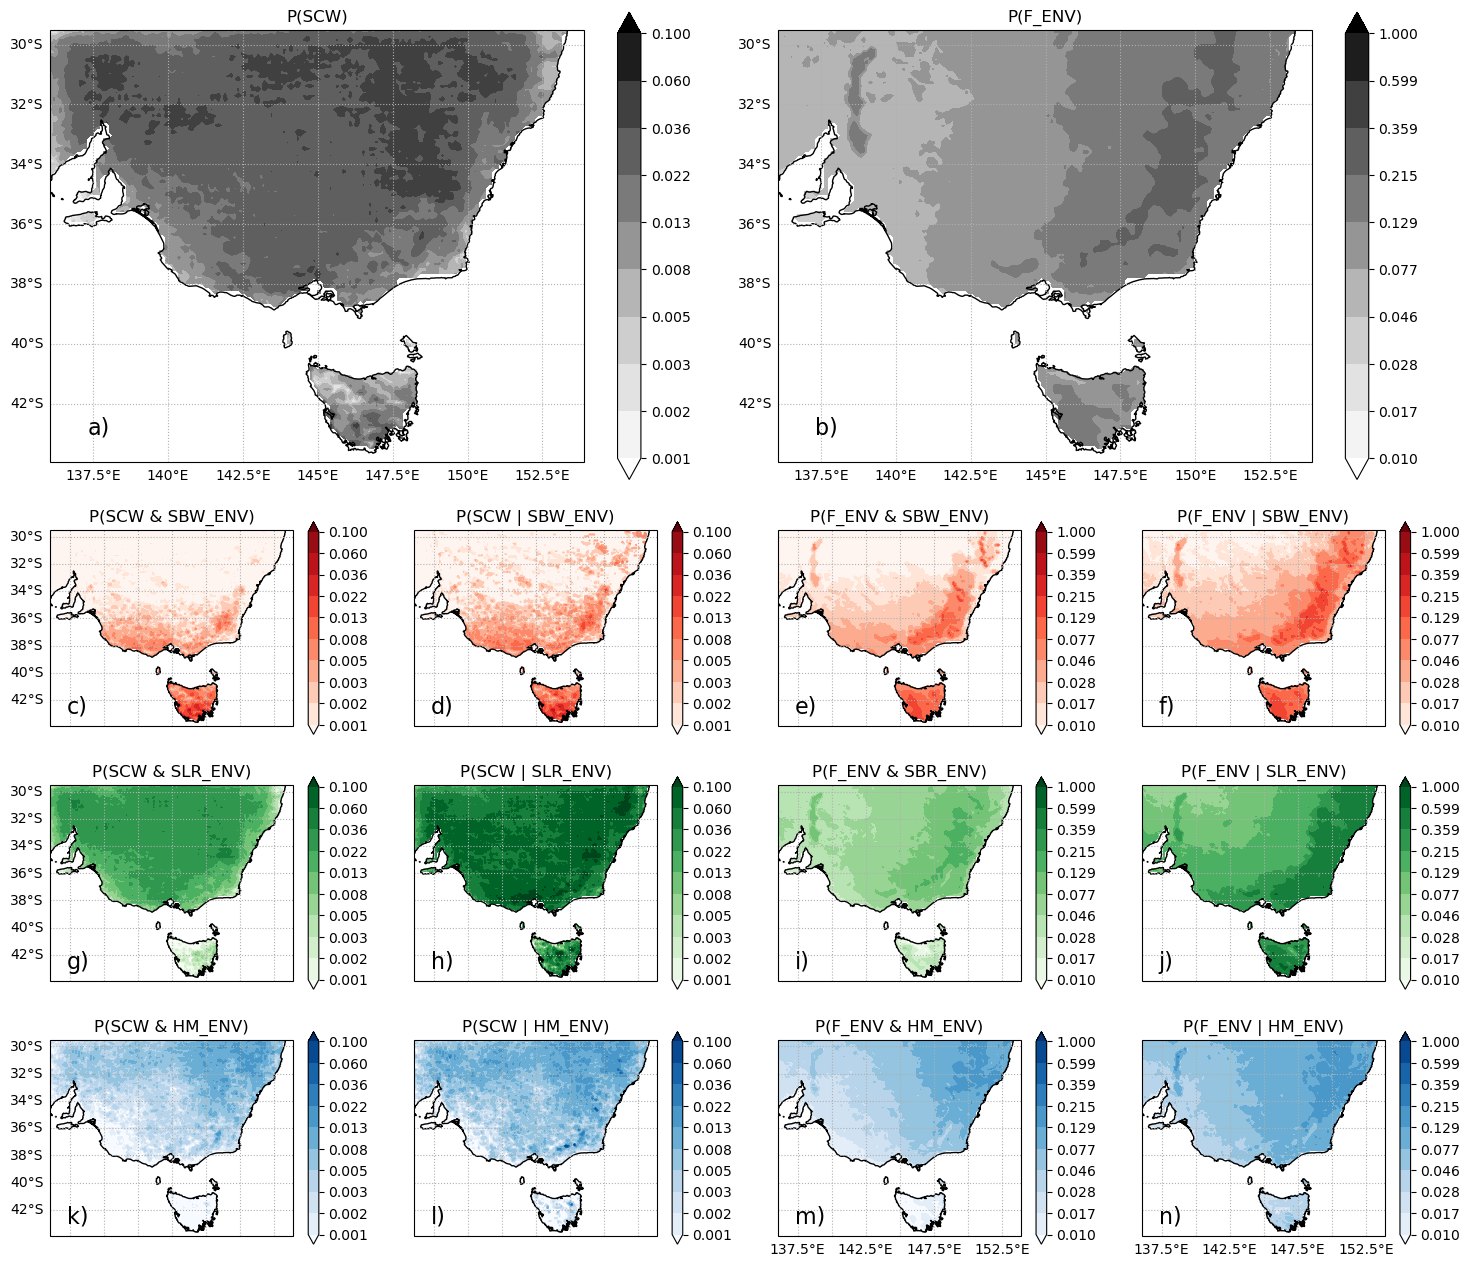

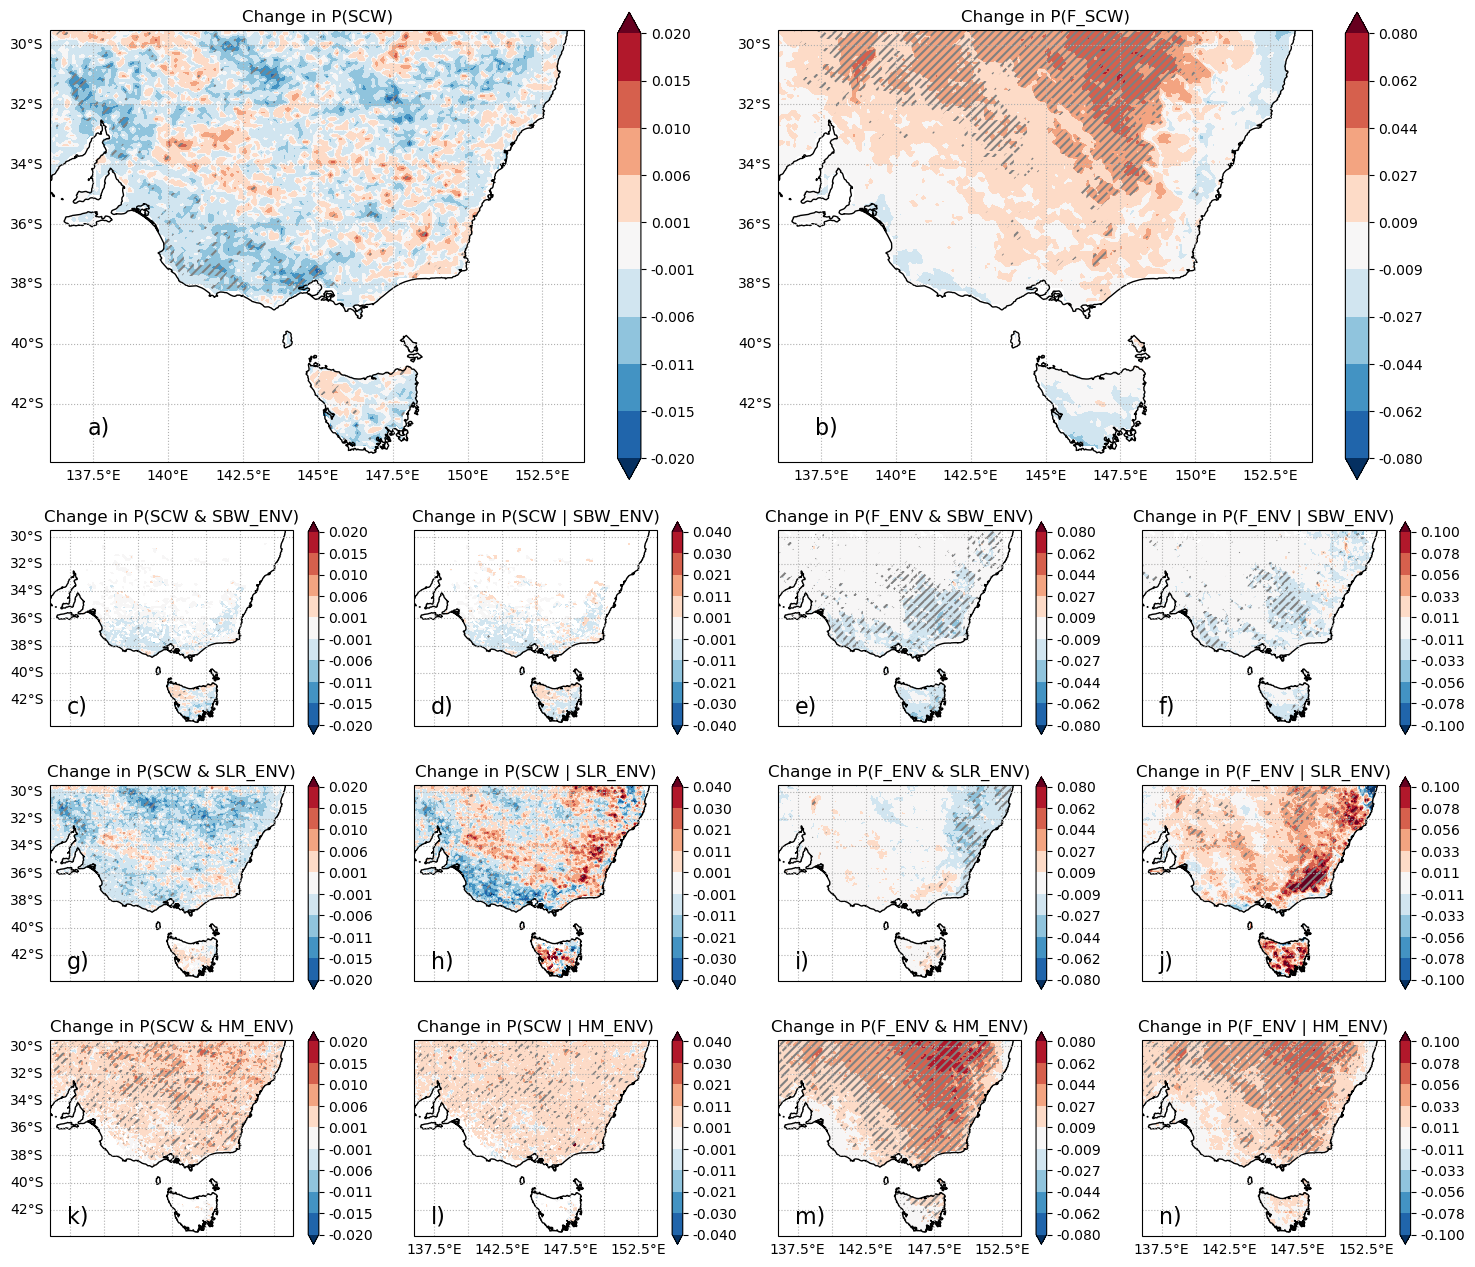

In [23]:
plt.figure(figsize=[18,16])
mpl.rcParams['hatch.linewidth'] = 1.5
np.random.seed(0)

shape=(5,4)

levs1 = np.logspace(-3,-1,10)
levs2 = np.logspace(-2,0,10)
#levs3 = np.linspace(-.04,.04,10)
levs3 = list(np.linspace(-0.04,-0.001,5)) + list(np.linspace(0.001,0.04,5))
levs4 = np.linspace(-.1,.1,10)
levs5 = list(np.linspace(-0.02,-0.001,5)) + list(np.linspace(0.001,0.02,5))
levs6 = np.linspace(-.08,.08,10)

def plot_sub(da, shape, loc, levs, letter, cmap=None, extend=None, rowspan=1, colspan=1, add_colorbar=True,left_labs=False,bottom_labs=False):
    labs=[]
    if left_labs:
        labs.append("left")
    if bottom_labs:
        labs.append("bottom")
    ax = plt.subplot2grid(shape,loc,rowspan=rowspan,colspan=colspan,projection=ccrs.PlateCarree())
    c=xr.plot.contourf(da, ax=ax,levels=levs,cmap=cmap,extend=extend,add_colorbar=False)
    if add_colorbar:
        fmt = lambda x, pos: '{:3.3f}'.format(x)
        cbar = plt.colorbar(c,format=FuncFormatter(fmt))
    ax.coastlines()
    ax.gridlines(ls=":",draw_labels=labs)
    ax.text(137.3,-43,letter+")",size=16)
    
    
def plot_sub_change(da1, da2, var, shape, loc, levs, letter, cmap=None, extend=None, rowspan=1, colspan=1, 
                    add_colorbar=False, N=1000, change_thresh=1,left_labs=False,bottom_labs=False):
    
    labs=[]
    if left_labs:
        labs.append("left")
    if bottom_labs:
        labs.append("bottom")    

    change, q2p5, q97p5 = calc_change(da1, da2, N, var)
    change = xr.where((da1[var].sum("year_month")>=change_thresh) & (da2[var].sum("year_month")>=change_thresh), change, np.nan)        

    ax = plt.subplot2grid(shape,loc,rowspan=rowspan,colspan=colspan,projection=ccrs.PlateCarree())
    c=xr.plot.contourf(change, ax=ax,levels=levs,cmap=cmap,extend=extend,add_colorbar=False)
    if add_colorbar:
        fmt = lambda x, pos: '{:3.3f}'.format(x)
        cbar = plt.colorbar(c,format=FuncFormatter(fmt))
    ax.coastlines()
    ax.gridlines(ls=":",draw_labels=labs)    
    ax.text(137.3,-43,letter+")",size=16)
    
    hatch = xr.plot.contourf((change>=q97p5) | (change<=q2p5), ax=ax,levels=[0.5,1.5],colors="none",hatches=["","////"],add_colorbar=False)
    for collection in hatch.collections:
        collection.set_edgecolor("grey")
        collection.set_linewidth(0.)
        
    
def plot_sub_change_cond(da1, da2, da1_cond, da2_cond, var, var_cond, shape, loc, levs, letter, cmap=None, extend=None, rowspan=1, colspan=1, 
                         add_colorbar=False, N=1000, change_thresh=1,left_labs=False,bottom_labs=False):
    
    labs=[]
    if left_labs:
        labs.append("left")
    if bottom_labs:
        labs.append("bottom")    
    
    change, q2p5, q97p5 = calc_change_conditional(da1, da2, da1_cond, da2_cond, N, var, var_cond)
    change = xr.where((da1[var].sum("year_month")>=change_thresh) & (da2[var].sum("year_month")>=change_thresh), change, np.nan)    
    
    ax = plt.subplot2grid(shape,loc,rowspan=rowspan,colspan=colspan,projection=ccrs.PlateCarree())
    c=xr.plot.contourf(change, ax=ax,levels=levs,cmap=cmap,extend=extend,add_colorbar=False)
    if add_colorbar:
        fmt = lambda x, pos: '{:3.3f}'.format(x)
        cbar = plt.colorbar(c,format=FuncFormatter(fmt))
    ax.coastlines()
    ax.gridlines(ls=":",draw_labels=labs)
    ax.text(137.3,-43,letter+")",size=16)
    
    hatch = xr.plot.contourf((change>=q97p5) | (change<=q2p5), ax=ax,levels=[0.5,1.5],colors="none",hatches=["","////"],add_colorbar=False)
    for collection in hatch.collections:
        collection.set_edgecolor("grey")
        collection.set_linewidth(0.)    

days_hist = len(scws_hist.attrs["daily_time"]) 
days_rcp = len(scws_rcp.attrs["daily_time"]) 


plot_sub((scws_hist.all_events.sum("year_month",skipna=False) / days_hist), shape, (0,0), levs1, "a", plt.get_cmap("Greys"), colspan=2,rowspan=2,add_colorbar=True,left_labs=True,bottom_labs=True,extend="both" ); plt.title("P(SCW)")
plot_sub( (bdsd_hist.clusterall_bdsd.sum("year_month",skipna=False) / days_hist), shape, (0,2), levs2, "b", plt.get_cmap("Greys"), colspan=2,rowspan=2,add_colorbar=True,left_labs=True,bottom_labs=True,extend="both"   ); plt.title("P(F_ENV)")

#Base state probabilities
plot_sub( (scws_hist.cluster0_events.sum("year_month",skipna=False) / days_hist), shape, (2,0), levs1, "c", plt.get_cmap("Reds"), extend="both",left_labs=True ); plt.title("P(SCW & SBW_ENV)")
plot_sub( (bdsd_hist.cluster0_bdsd.sum("year_month",skipna=False) / days_hist), shape, (2,2), levs2, "e", plt.get_cmap("Reds"), extend="both" ); plt.title("P(F_ENV & SBW_ENV)")
plot_sub( (scws_hist.cluster1_events.sum("year_month",skipna=False) / days_hist), shape, (3,0), levs1, "g", plt.get_cmap("Greens"), extend="both",left_labs=True ); plt.title("P(SCW & SLR_ENV)")
plot_sub( (bdsd_hist.cluster1_bdsd.sum("year_month",skipna=False) / days_hist), shape, (3,2), levs2, "i", plt.get_cmap("Greens"), extend="both"); plt.title("P(F_ENV & SBR_ENV)")
plot_sub( (scws_hist.cluster2_events.sum("year_month",skipna=False) / days_hist), shape, (4,0), levs1, "k", plt.get_cmap("Blues"), extend="both",left_labs=True ); plt.title("P(SCW & HM_ENV)")
plot_sub( (bdsd_hist.cluster2_bdsd.sum("year_month",skipna=False) / days_hist), shape, (4,2), levs2, "m", plt.get_cmap("Blues"), extend="both",bottom_labs=True ); plt.title("P(F_ENV & HM_ENV)")


#Base state conditional probabilities
plot_sub( (scws_hist.cluster0_events.sum("year_month",skipna=False) / days_hist) / \
         (bdsd_hist.cluster0.sum("year_month",skipna=False) / days_hist), 
         shape, (2,1), levs1, "d", plt.get_cmap("Reds") , extend="both",add_colorbar=True) ; plt.title("P(SCW | SBW_ENV)")
plot_sub( (bdsd_hist.cluster0_bdsd.sum("year_month",skipna=False) / days_hist) / \
         (bdsd_hist.cluster0.sum("year_month",skipna=False) / days_hist), 
         shape, (2,3), levs2, "f", plt.get_cmap("Reds") , extend="both",add_colorbar=True); plt.title("P(F_ENV | SBW_ENV)")
plot_sub( (scws_hist.cluster1_events.sum("year_month",skipna=False) / days_hist) / \
         (bdsd_hist.cluster1.sum("year_month",skipna=False) / days_hist), 
         shape, (3,1), levs1, "h", plt.get_cmap("Greens") , extend="both",add_colorbar=True) ; plt.title("P(SCW | SLR_ENV)")
plot_sub( (bdsd_hist.cluster1_bdsd.sum("year_month",skipna=False) / days_hist) / \
         (bdsd_hist.cluster1.sum("year_month",skipna=False) / days_hist), 
         shape, (3,3), levs2, "j", plt.get_cmap("Greens") , extend="both",add_colorbar=True); plt.title("P(F_ENV | SLR_ENV)")
plot_sub( (scws_hist.cluster2_events.sum("year_month",skipna=False) / days_hist) / \
         (bdsd_hist.cluster2.sum("year_month",skipna=False) / days_hist), 
         shape, (4,1), levs1, "l", plt.get_cmap("Blues") , extend="both",add_colorbar=True) ; plt.title("P(SCW | HM_ENV)")
plot_sub( (bdsd_hist.cluster2_bdsd.sum("year_month",skipna=False) / days_hist) / \
         (bdsd_hist.cluster2.sum("year_month",skipna=False) / days_hist), 
         shape, (4,3), levs2, "n", plt.get_cmap("Blues") , extend="both",add_colorbar=True,bottom_labs=True); plt.title("P(F_ENV | HM_ENV)")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/spatial_clim_barpacm.jpeg",dpi=400,bbox_inches="tight")

plt.figure(figsize=[18,16])


plot_sub_change( scws_hist, scws_rcp, "all_events", shape, (0,0), levs5, "a", extend="both", colspan=2,rowspan=2,add_colorbar=True,left_labs=True,bottom_labs=True ); plt.title("Change in P(SCW)")
plot_sub_change( bdsd_hist, bdsd_rcp, "clusterall_bdsd", shape, (0,2), levs6, "b", extend="both", colspan=2,rowspan=2,add_colorbar=True,left_labs=True,bottom_labs=True ); plt.title("Change in P(F_SCW)")

#Change in probabilities
plot_sub_change(scws_hist, scws_rcp, "cluster0_events", shape, (2,0), levs5, "c", plt.get_cmap("RdBu_r"), extend="both",add_colorbar=True,left_labs=True); plt.title("Change in P(SCW & SBW_ENV)")
plot_sub_change(bdsd_hist, bdsd_rcp, "cluster0_bdsd", shape, (2,2), levs6, "e", plt.get_cmap("RdBu_r"), extend="both",add_colorbar=True); plt.title("Change in P(F_ENV & SBW_ENV)")

plot_sub_change( scws_hist,scws_rcp, "cluster1_events", shape, (3,0), levs5, "g", plt.get_cmap("RdBu_r"), extend="both",add_colorbar=True,left_labs=True); plt.title("Change in P(SCW & SLR_ENV)")
plot_sub_change( bdsd_hist,bdsd_rcp, "cluster1_bdsd", shape, (3,2), levs6, "i", plt.get_cmap("RdBu_r"), extend="both",add_colorbar=True); plt.title("Change in P(F_ENV & SLR_ENV)")

plot_sub_change( scws_hist, scws_rcp, "cluster2_events", shape, (4,0), levs5, "k", plt.get_cmap("RdBu_r"), extend="both",add_colorbar=True,left_labs=True); plt.title("Change in P(SCW & HM_ENV)")
plot_sub_change( bdsd_hist, bdsd_rcp, "cluster2_bdsd",shape, (4,2), levs6, "m", plt.get_cmap("RdBu_r"), extend="both",add_colorbar=True,bottom_labs=True); plt.title("Change in P(F_ENV & HM_ENV)")

#Change in conditional probabilities
plot_sub_change_cond(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, "cluster0_events", "cluster0", shape, (2,1), levs3, "d", plt.get_cmap("RdBu_r"), extend="both", add_colorbar=True ) ; plt.title("Change in P(SCW | SBW_ENV)")
plot_sub_change_cond(bdsd_hist, bdsd_rcp, bdsd_hist, bdsd_rcp, "cluster0_bdsd", "cluster0", shape, (2,3), levs4, "f", plt.get_cmap("RdBu_r"), extend="both", add_colorbar=True ) ; plt.title("Change in P(F_ENV | SBW_ENV)")

plot_sub_change_cond(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, "cluster1_events", "cluster1", shape, (3,1), levs3, "h", plt.get_cmap("RdBu_r"), extend="both", add_colorbar=True ) ; plt.title("Change in P(SCW | SLR_ENV)")
plot_sub_change_cond(bdsd_hist, bdsd_rcp, bdsd_hist, bdsd_rcp, "cluster1_bdsd", "cluster1", shape, (3,3), levs4, "j", plt.get_cmap("RdBu_r"), extend="both", add_colorbar=True ) ; plt.title("Change in P(F_ENV | SLR_ENV)")

plot_sub_change_cond(scws_hist, scws_rcp, bdsd_hist, bdsd_rcp, "cluster2_events", "cluster2", shape, (4,1), levs3, "l", plt.get_cmap("RdBu_r"), extend="both", add_colorbar=True, bottom_labs=True ) ; plt.title("Change in P(SCW | HM_ENV)")
plot_sub_change_cond(bdsd_hist, bdsd_rcp, bdsd_hist, bdsd_rcp, "cluster2_bdsd", "cluster2", shape, (4,3), levs4, "n", plt.get_cmap("RdBu_r"), extend="both", add_colorbar=True, bottom_labs=True ) ; plt.title("Change in P(F_ENV | HM_ENV)")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/future_spatial_changes_barpacm.jpeg",dpi=400,bbox_inches="tight")

Conditional probability of SCW event given favourable environment


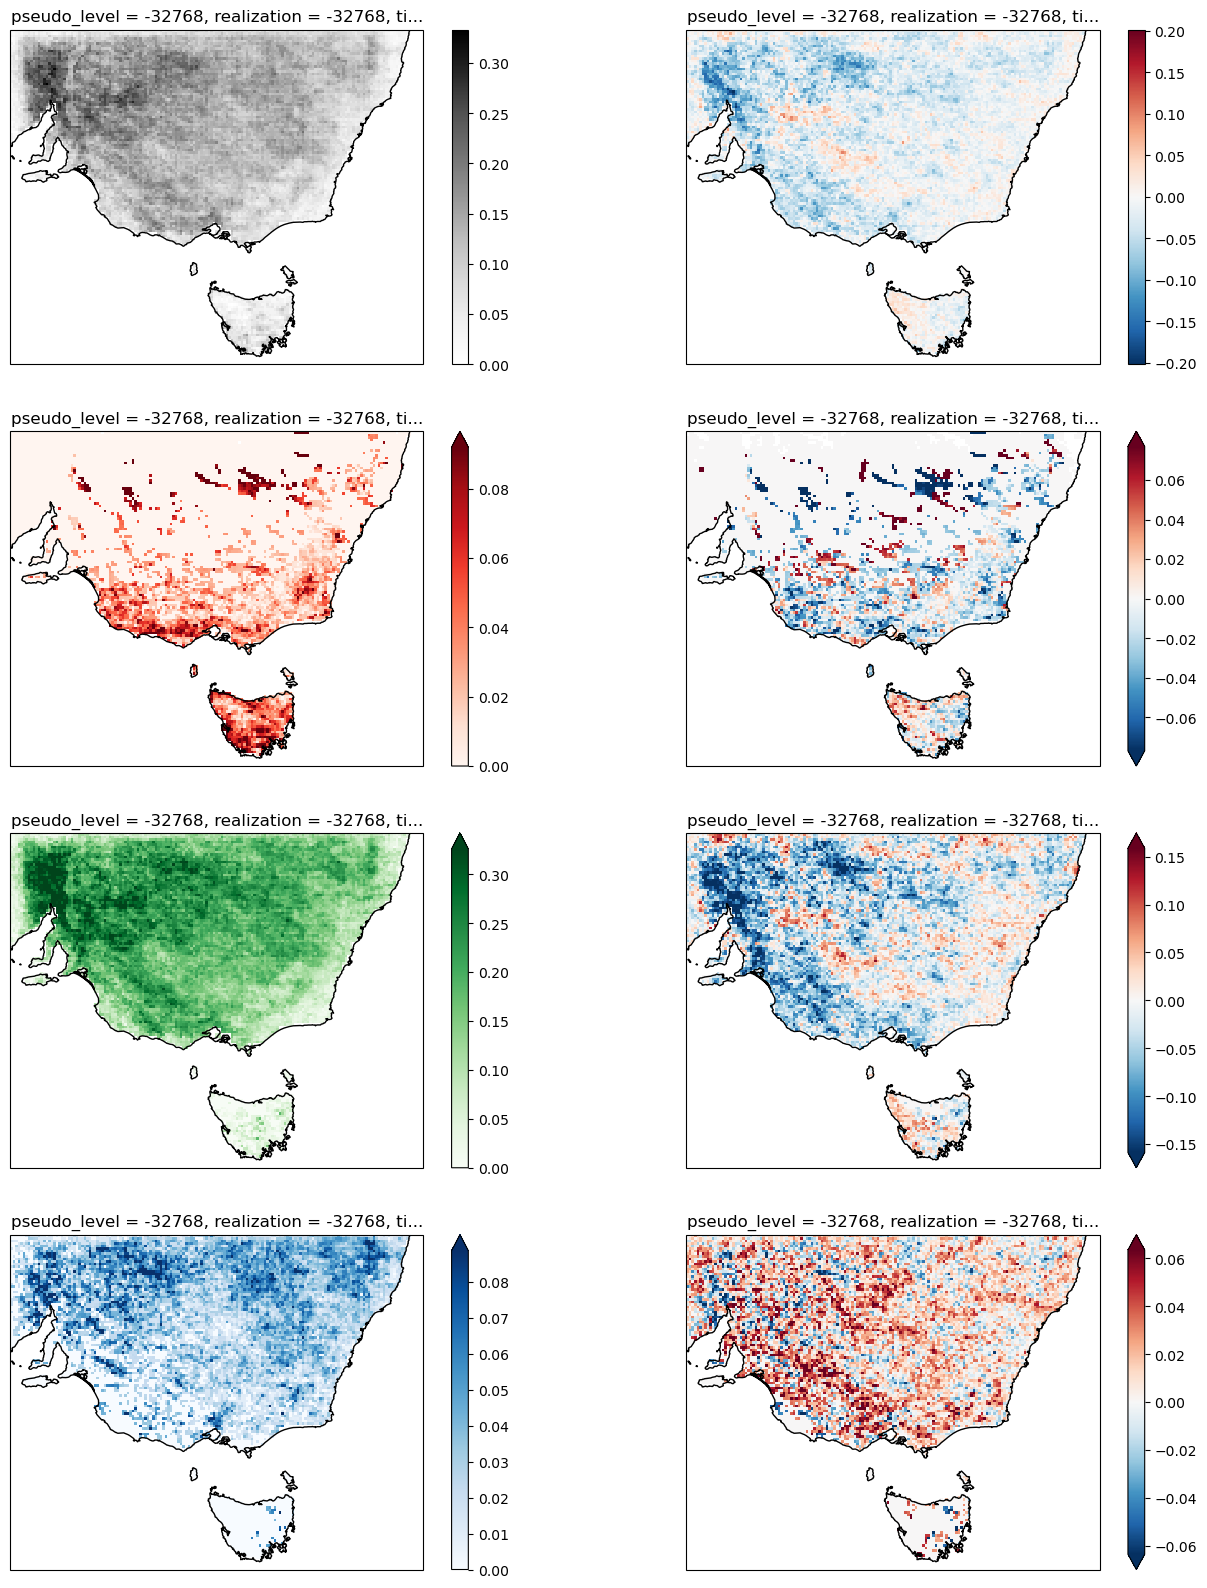

In [16]:
print("Conditional probability of SCW event given favourable environment")

plt.figure(figsize=[16,20])

ax=plt.subplot(4,2,1,projection=ccrs.PlateCarree())
env_prob_hist = (bdsd_hist.clusterall_bdsd.sum("year_month",skipna=False) / days_hist)
scw_and_env_prob_hist = (scw_bdsd_hist.clusterall.sum("year_month",skipna=False) / days_hist)
scw_prob_given_env_hist = scw_and_env_prob_hist / env_prob_hist
scw_prob_given_env_hist.plot(ax=ax,cmap=plt.get_cmap("Greys"))
ax.coastlines()

ax=plt.subplot(4,2,2,projection=ccrs.PlateCarree())
env_prob_rcp = (bdsd_rcp.clusterall_bdsd.sum("year_month",skipna=False) / days_rcp)
scw_and_env_prob_rcp = (scw_bdsd_rcp.clusterall.sum("year_month",skipna=False) / days_rcp)
scw_prob_given_env_rcp = scw_and_env_prob_rcp / env_prob_rcp
(scw_prob_given_env_rcp - scw_prob_given_env_hist).plot(ax=ax)
ax.coastlines()

ax=plt.subplot(4,2,3,projection=ccrs.PlateCarree())
env_prob_hist = (bdsd_hist.cluster0_bdsd.sum("year_month",skipna=False) / days_hist)
scw_and_env_prob_hist = (scw_bdsd_hist.cluster0.sum("year_month",skipna=False) / days_hist)
scw_prob_given_env_hist = scw_and_env_prob_hist / env_prob_hist
scw_prob_given_env_hist.plot(ax=ax,cmap=plt.get_cmap("Reds"),robust=True)
ax.coastlines()

ax=plt.subplot(4,2,4,projection=ccrs.PlateCarree())
env_prob_rcp = (bdsd_rcp.cluster0_bdsd.sum("year_month",skipna=False) / days_rcp)
scw_and_env_prob_rcp = (scw_bdsd_rcp.cluster0.sum("year_month",skipna=False) / days_rcp)
scw_prob_given_env_rcp = scw_and_env_prob_rcp / env_prob_rcp
(scw_prob_given_env_rcp - scw_prob_given_env_hist).plot(ax=ax,robust=True)
ax.coastlines()

ax=plt.subplot(4,2,5,projection=ccrs.PlateCarree())
env_prob_hist = (bdsd_hist.cluster1_bdsd.sum("year_month",skipna=False) / days_hist)
scw_and_env_prob_hist = (scw_bdsd_hist.cluster1.sum("year_month",skipna=False) / days_hist)
scw_prob_given_env_hist = scw_and_env_prob_hist / env_prob_hist
scw_prob_given_env_hist.plot(ax=ax,cmap=plt.get_cmap("Greens"),robust=True)
ax.coastlines()

ax=plt.subplot(4,2,6,projection=ccrs.PlateCarree())
env_prob_rcp = (bdsd_rcp.cluster1_bdsd.sum("year_month",skipna=False) / days_rcp)
scw_and_env_prob_rcp = (scw_bdsd_rcp.cluster1.sum("year_month",skipna=False) / days_rcp)
scw_prob_given_env_rcp = scw_and_env_prob_rcp / env_prob_rcp
(scw_prob_given_env_rcp - scw_prob_given_env_hist).plot(ax=ax,robust=True)
ax.coastlines()

ax=plt.subplot(4,2,7,projection=ccrs.PlateCarree())
env_prob_hist = (bdsd_hist.cluster2_bdsd.sum("year_month",skipna=False) / days_hist)
scw_and_env_prob_hist = (scw_bdsd_hist.cluster2.sum("year_month",skipna=False) / days_hist)
scw_prob_given_env_hist = scw_and_env_prob_hist / env_prob_hist
scw_prob_given_env_hist.plot(ax=ax,cmap=plt.get_cmap("Blues"),robust=True)
ax.coastlines()

ax=plt.subplot(4,2,8,projection=ccrs.PlateCarree())
env_prob_rcp = (bdsd_rcp.cluster2_bdsd.sum("year_month",skipna=False) / days_rcp)
scw_and_env_prob_rcp = (scw_bdsd_rcp.cluster2.sum("year_month",skipna=False) / days_rcp)
scw_prob_given_env_rcp = scw_and_env_prob_rcp / env_prob_rcp
(scw_prob_given_env_rcp - scw_prob_given_env_hist).plot(ax=ax,robust=True)
ax.coastlines()

Conditional probability of SCW event given favourable environment


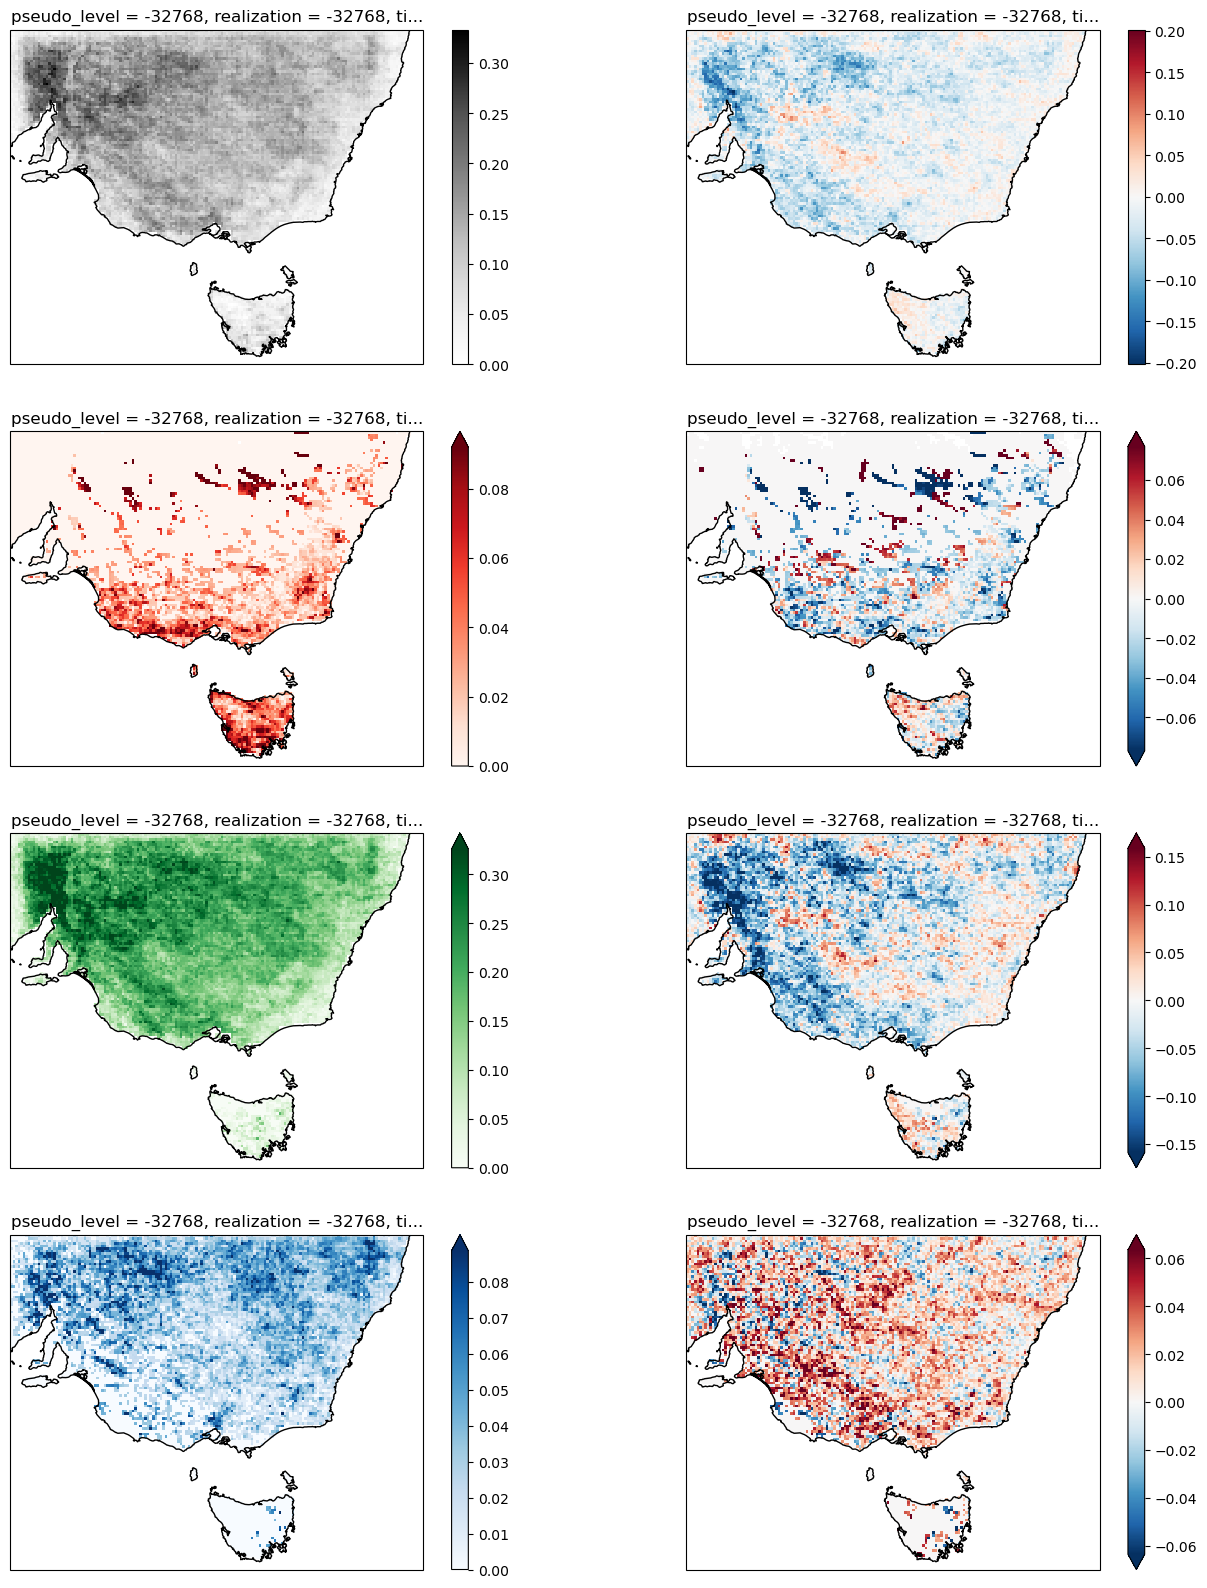

In [17]:
print("Conditional probability of SCW event given favourable environment")

plt.figure(figsize=[16,20])

ax=plt.subplot(4,2,1,projection=ccrs.PlateCarree())
env_prob_hist = (bdsd_hist.clusterall_bdsd.sum("year_month",skipna=False) / days_hist)
scw_and_env_prob_hist = (scw_bdsd_hist.clusterall.sum("year_month",skipna=False) / days_hist)
scw_prob_given_env_hist = scw_and_env_prob_hist / env_prob_hist
scw_prob_given_env_hist.plot(ax=ax,cmap=plt.get_cmap("Greys"))
ax.coastlines()

ax=plt.subplot(4,2,2,projection=ccrs.PlateCarree())
env_prob_rcp = (bdsd_rcp.clusterall_bdsd.sum("year_month",skipna=False) / days_rcp)
scw_and_env_prob_rcp = (scw_bdsd_rcp.clusterall.sum("year_month",skipna=False) / days_rcp)
scw_prob_given_env_rcp = scw_and_env_prob_rcp / env_prob_rcp
(scw_prob_given_env_rcp - scw_prob_given_env_hist).plot(ax=ax)
ax.coastlines()

ax=plt.subplot(4,2,3,projection=ccrs.PlateCarree())
env_prob_hist = (bdsd_hist.cluster0_bdsd.sum("year_month",skipna=False) / days_hist)
scw_and_env_prob_hist = (scw_bdsd_hist.cluster0.sum("year_month",skipna=False) / days_hist)
scw_prob_given_env_hist = scw_and_env_prob_hist / env_prob_hist
scw_prob_given_env_hist.plot(ax=ax,cmap=plt.get_cmap("Reds"),robust=True)
ax.coastlines()

ax=plt.subplot(4,2,4,projection=ccrs.PlateCarree())
env_prob_rcp = (bdsd_rcp.cluster0_bdsd.sum("year_month",skipna=False) / days_rcp)
scw_and_env_prob_rcp = (scw_bdsd_rcp.cluster0.sum("year_month",skipna=False) / days_rcp)
scw_prob_given_env_rcp = scw_and_env_prob_rcp / env_prob_rcp
(scw_prob_given_env_rcp - scw_prob_given_env_hist).plot(ax=ax,robust=True)
ax.coastlines()

ax=plt.subplot(4,2,5,projection=ccrs.PlateCarree())
env_prob_hist = (bdsd_hist.cluster1_bdsd.sum("year_month",skipna=False) / days_hist)
scw_and_env_prob_hist = (scw_bdsd_hist.cluster1.sum("year_month",skipna=False) / days_hist)
scw_prob_given_env_hist = scw_and_env_prob_hist / env_prob_hist
scw_prob_given_env_hist.plot(ax=ax,cmap=plt.get_cmap("Greens"),robust=True)
ax.coastlines()

ax=plt.subplot(4,2,6,projection=ccrs.PlateCarree())
env_prob_rcp = (bdsd_rcp.cluster1_bdsd.sum("year_month",skipna=False) / days_rcp)
scw_and_env_prob_rcp = (scw_bdsd_rcp.cluster1.sum("year_month",skipna=False) / days_rcp)
scw_prob_given_env_rcp = scw_and_env_prob_rcp / env_prob_rcp
(scw_prob_given_env_rcp - scw_prob_given_env_hist).plot(ax=ax,robust=True)
ax.coastlines()

ax=plt.subplot(4,2,7,projection=ccrs.PlateCarree())
env_prob_hist = (bdsd_hist.cluster2_bdsd.sum("year_month",skipna=False) / days_hist)
scw_and_env_prob_hist = (scw_bdsd_hist.cluster2.sum("year_month",skipna=False) / days_hist)
scw_prob_given_env_hist = scw_and_env_prob_hist / env_prob_hist
scw_prob_given_env_hist.plot(ax=ax,cmap=plt.get_cmap("Blues"),robust=True)
ax.coastlines()

ax=plt.subplot(4,2,8,projection=ccrs.PlateCarree())
env_prob_rcp = (bdsd_rcp.cluster2_bdsd.sum("year_month",skipna=False) / days_rcp)
scw_and_env_prob_rcp = (scw_bdsd_rcp.cluster2.sum("year_month",skipna=False) / days_rcp)
scw_prob_given_env_rcp = scw_and_env_prob_rcp / env_prob_rcp
(scw_prob_given_env_rcp - scw_prob_given_env_hist).plot(ax=ax,robust=True)
ax.coastlines()